In [1]:
# グラフ描画系

import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
from matplotlib_venn import venn2, venn2_circles
from matplotlib import animation as ani
from IPython.display import Image

import os
plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

%matplotlib inline
%config InlineBackend.figure_format='retina'

import logging
import time
from typing import List, Optional, Union, Tuple, Dict
# from encoders import frequency_encoding
from contextlib import contextmanager
import sys
sys.path.append('../py/')
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', 1000)

from abc import ABCMeta, abstractmethod


In [2]:
import gc
from pathlib import Path
import numpy as np
import pandas as pd
import datetime
from time import time
from tqdm import tqdm_notebook as tqdm
import lightgbm as lgb
from collections import Counter
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, cohen_kappa_score
import time
#  pandas setting
pd.set_option("display.max_colwidth", 100)
# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:,.5f}'.format

from abc import ABCMeta, abstractmethod
from pathlib import Path

import scipy
import random
from joblib import Parallel, delayed
import multiprocessing

In [3]:
def unpickle(filename):
    with open(filename, 'rb') as fo:
        p = pickle.load(fo)
    return p

def to_pickle(filename, obj):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, -1)
        
class ModelExtractionCallback(object):
    """Callback class for retrieving trained model from lightgbm.cv()
    NOTE: This class depends on '_CVBooster' which is hidden class, so it might doesn't work if the specification is changed.
    from: https://blog.amedama.jp/entry/2019/08/14/235421
    """

    def __init__(self):
        self._model = None

    def __call__(self, env):
        # Saving _CVBooster object.
        self._model = env.model

    def _assert_called_cb(self):
        if self._model is None:
            # Throw exception if the callback class is not called.
            raise RuntimeError('callback has not called yet')

    @property
    def boosters_proxy(self):
        self._assert_called_cb()
        # return Booster object
        return self._model

    @property
    def raw_boosters(self):
        self._assert_called_cb()
        # return list of Booster
        return self._model.boosters

    @property
    def best_iteration(self):
        self._assert_called_cb()
        # return boosting round when early stopping.
        return self._model.best_iteration
    
def check_gpu_available():
    try:
        import torch
        return torch.cuda.is_available()
    except Exception as e:
        print(e)
        return False
    
class GBDTWrapper(object):

    def __init__(self, seed=71):
        self.param = {}
        self.fold_seed = 0
        self.seed = seed
        self.use_gpu = check_gpu_available()

    def calc_score(self, score_type, target, oof):
        if score_type == "auc":
            score = roc_auc_score(target, oof)
            print(f"auc on oof preds: {score}")
        elif score_type == "rmse":
            score = np.sqrt(mean_squared_error(target, oof))
            print(f"rmse on oof preds: {score}")
            
        elif score_type == "mae":
            score = mean_absolute_error(target, oof)
            print(f"mae on oof preds: {score}")
        else:
            raise NotImplementedError
        return score

    @property
    def seed(self):
        return self.seed

    @seed.setter
    def seed(self, value):
        self.param["seed"] = value
        self.param["bagging_seed"] = value + 1
        self.param["feature_fraction_seed"] = value + 2
        self.param["drop_seed"] = value + 3
        self.fold_seed = value + 4

    def rank_average(self, preds):
        ranked_pred = rankdata(preds)
        return (ranked_pred - np.min(ranked_pred)) / (np.max(ranked_pred) - np.min(ranked_pred))

class LightGBMWrapper(GBDTWrapper):

    def __init__(self, train:pd.DataFrame,
                 target:list,
                 param:dict,
                 test:pd.DataFrame = None,
                 stratified:bool=False,
                 kfold_shuffle:bool=False,
                 fold_num:int=5,
                 fold_type:str="kfold",
                 group=None,
                 early_stopping_rounds:int=None,
                 categorical_features:list=[],
                 rank_ave:bool=False,
                 base_oof:list=None,
                 seed:int=71,
                 verbose_eval=100):
        super(LightGBMWrapper, self).__init__(seed=seed)
        self.param:dict = param
        self.train:pd.DataFrame = train
        self.test:pd.DataFrame = test
        self.target:list = target
        self.rank_ave:bool = rank_ave
        self.categorical_features:list = categorical_features
        self.fold_type:str = fold_type
        assert fold_type in ["kfold", "stratified", "group"]
        self.kfold_shuffle:bool = kfold_shuffle
        self.early_stopping_rounds:int = early_stopping_rounds
        self.base_oof = base_oof
        self.verbose_eval:bool = verbose_eval
        self.ret_dict:dict = {}
        self.models:list = []
        self.group = group
        self.fold_num:int=fold_num
        self.seed = seed
        
    def fit_predict_cv(self):
        lgb_train = lgb.Dataset(self.train, self.target, init_score=self.base_oof)

        extraction_cb = ModelExtractionCallback()
        callbacks = [extraction_cb]
        print(self.param)

        if self.fold_type == "stratified":
            folds = StratifiedKFold(n_splits=self.fold_num, shuffle=True, random_state=self.fold_seed)
        elif self.fold_type == "kfold":
            folds = KFold(n_splits=self.fold_num, shuffle=self.kfold_shuffle, random_state=self.fold_seed)
        elif self.fold_type == "group":
            assert self.group is not None
            folds = GroupKFold(n_splits=self.fold_num)
            fold_iter = folds.split(self.train, self.target, groups=self.group)
            split_list = []
            for n_fold, (trn_idx, val_idx) in enumerate(fold_iter):
                split_list.append([trn_idx, val_idx])
            folds = split_list 
        else:
            assert False

        history = lgb.cv(params=self.param,
                         train_set=lgb_train,
                         categorical_feature=self.categorical_features,
                         folds=folds,
                         verbose_eval=self.verbose_eval,
                         early_stopping_rounds=self.early_stopping_rounds,
                         callbacks=callbacks,
                         )

        boosters = extraction_cb.raw_boosters
        self.models = boosters
        self.best_iteration = extraction_cb.best_iteration

        importance_df = pd.DataFrame([b.feature_importance(importance_type="gain") for b in boosters]).T
        importance_df.index = self.train.columns
        importance_df["ave"] = importance_df.mean(axis=1)
        importance_df.sort_values("ave", ascending=False, inplace=True)

        if self.fold_type != "group":
            fold_iter = folds.split(self.train, self.target)
        else:
            fold_iter = folds
        val_index_list = []
        oof_list = []
        for n_fold, ((trn_idx, val_idx), booster) in enumerate(zip(fold_iter, boosters)):
            valid = self.train.iloc[val_idx]
            oof = booster.predict(valid, num_iteration=self.best_iteration)
            if self.rank_ave:
                oof = self.rank_average(oof)
            oof_list += [oof]
            val_index_list += [val_idx]

        val_index = np.argsort(np.concatenate(val_index_list))
        oof_preds = np.concatenate(oof_list)

        score = self.calc_score("rmse", self.target, oof_preds[val_index])

        self.ret_dict = {}
        self.ret_dict["oof_preds"] = oof_preds[val_index]
        self.ret_dict["auc_score"] = score
        self.ret_dict["history"] = history
        self.ret_dict["importance_df"] = importance_df
        
        # Predicting with test data of each CV separately.
        if self.test is not None:
            predict()
            
        return self.ret_dict
    
    def predict(self):
            y_preds = np.zeros((self.test.shape[0], self.fold_num))
            for i, booster in enumerate(self.models):
                y_preds[:, i] = booster.predict(self.test, num_iteration=self.best_iteration)
                if self.rank_ave:
                    y_preds[:, i] = self.rank_average(y_preds[:, i])
            y_preds = np.mean(y_preds, axis=1)
            if self.rank_ave:
                oof_preds = self.rank_average(oof_preds)
                y_preds = self.rank_average(y_preds)
            self.ret_dict["y_preds"] = y_preds
            

clip_time = {'Welcome to Lost Lagoon!':19,'Tree Top City - Level 1':17,'Ordering Spheres':61, 'Costume Box':61,
        '12 Monkeys':109,'Tree Top City - Level 2':25, 'Pirate\'s Tale':80, 'Treasure Map':156,'Tree Top City - Level 3':26,
        'Rulers':126, 'Magma Peak - Level 1':20, 'Slop Problem':60, 'Magma Peak - Level 2':22, 'Crystal Caves - Level 1':18,
        'Balancing Act':72, 'Lifting Heavy Things':118,'Crystal Caves - Level 2':24, 'Honey Cake':142, 'Crystal Caves - Level 3':19,
        'Heavy, Heavier, Heaviest':61}

# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
        
    # news features: time spent in each activity
    time_spent_each_act = {actv: 0 for actv in list_of_user_activities} # added
    # event_code_count = {eve: 0 for eve in list_of_event_code} # added
    last_session_time_sec = 0 # added
    
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    clip_durations = []
    accumulated_accuracy_group = 0
    accumulated_accuracy=0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0 
    accumulated_actions = 0
    counter = 0
    accumulated_correct = 0
    accumulated_net_correct = 0
    accumu_asses_correct = 0
    accumu_asses_net_correct = 0
    max_level = 0
    Activity_mean_event_count = 0
    Game_mean_event_count = 0
    
    mean_game_round = 0
    event_dict_all = {}
    missed_features = defaultdict(int)
    
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    last_accuracy_title = {'acc_' + activities_labels[title]: -1 for title in assess_titles}
    
    event_code_first_char = {"head_code_2":0, "head_code_3":0, "head_code_4":0, "head_code_5":0}
    title_count = {eve: 0 for eve in activities_labels.values()} 
    
    time_first_activity = float(user_sample['timestamp'].values[0]) # added
    title_event_code_count = {t_eve: 0 for t_eve in all_title_event_code}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
        
    durations = []
    game_durations = []
    activity_durations = []
    session_inst_id = user_sample.iloc[0].installation_id 
    # itarates through each session of one instalation_id
    session_count = 0
    for i, session in user_sample.groupby('game_session', sort=False):        
        session_count += 1
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        user_activities_count["inst_game_id"] = session_inst_id + "_" + session['game_session'].iloc[0]
         
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
            
        # get current session time in seconds
        if session_type != 'Assessment': # added
            time_spent = int(session['game_time'].iloc[-1] / 1000) # added
            time_spent_each_act[activities_labels[session_title]] += time_spent # added
            
        if (session_type == 'Activity'):
            activity_durations += [(session.iloc[-1, 2] - session.iloc[0, 2] ).seconds]
            Activity_mean_event_count = (Activity_mean_event_count + session['event_count'].iloc[-1])/2.0
            
        if (session_type == 'Game'):
            game_durations += [(session.iloc[-1, 2] - session.iloc[0, 2] ).seconds]
            Game_mean_event_count = (Game_mean_event_count + session['event_count'].iloc[-1])/2.0
            
            correct_ans = session["correct"]
            if len(session["correct"].dropna()) > 0: # correct_ans is not np.nan
                accumulated_net_correct += session["correct"].sum() 
                correct_cnt = session["correct"].value_counts()
                if 1.0 in correct_cnt.to_dict().keys():
                    accumulated_correct += correct_cnt.loc[1.0]
                    
        if session_type == 'Clip':
            clip_durations.append((clip_time[activities_labels[session_title]]))
            
        if len(session["level"].dropna()) > 0: # correct_ans is not np.nan
            max_level = np.max([session["level"].max(), max_level])
                
        try:
            game_round = json.loads(session['event_data'].iloc[-1])["round"]
            mean_game_round =  (mean_game_round + game_round)/2.0
        except:
            pass
        
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):            
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features['game_session'] = i            
            print(features["game_session"])
            features.update(time_spent_each_act.copy()) # added
            features.update(event_code_count.copy()) # added
            features.update(event_code_first_char.copy())
            features.update(event_dict_all.copy())
            features.update(missed_features.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            
            variety_features = [('var_event_code', event_code_count),
                               ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count)]
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
                
            
            features['min_hour'] = session["hour"].iloc[0]
            features['accumulated_net_correct'] = accumulated_net_correct
            features['accumulated_correct'] = accumulated_correct
            features['max_level'] = max_level
            
            features['Game_mean_event_count'] = Game_mean_event_count
            features['Activity_mean_event_count'] = Activity_mean_event_count
            features['mean_game_round'] = mean_game_round
            features['accumu_asses_correct'] = accumu_asses_correct
            features['accumu_asses_net_correct'] = accumu_asses_net_correct

            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0] 
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
                
            if activity_durations == []:
                features['activity_duration_mean'] = 0
                features['activity_duration_std'] = 0
            else:
                features['activity_duration_mean'] = np.mean(activity_durations)
                features['activity_duration_std'] = np.std(activity_durations)
                
            if game_durations == []:
                features['game_duration_mean'] = 0
                features['game_duration_std'] = 0
            else:
                features['game_duration_mean'] = np.mean(game_durations)
                features['game_duration_std'] = np.std(game_durations)

            if clip_durations == []:
                features['Clip_duration_mean'] = 0
                features['Clip_duration_std'] = 0
            else:
                features['Clip_duration_mean'] = np.mean(clip_durations)
                features['Clip_duration_std'] = np.std(clip_durations)
                
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            
            features['session_count'] = session_count
            
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1

        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_id_count = update_counters(event_id_count, "event_id")
        
        
        
        miss_df = session[session.event_id.isin(event_list_with_misses)]
        if len(miss_df)>0:
            misses_data = pd.DataFrame(miss_df.event_data.apply(lambda x: json.loads(x)).values.tolist())["misses"]
            missed_features["misses_mean"] += misses_data.mean()
            missed_features["misses_std"] += misses_data.std()
            missed_features["misses_max"] = np.max([missed_features["misses_max"] , misses_data.max()])
            
        if (session_type == 'Assessment'):
            correct_ans = session["correct"]
            if len(session["correct"].dropna()) > 0: # correct_ans is not np.nan
                accumu_asses_net_correct += session["correct"].sum() 
                correct_cnt = session["correct"].value_counts()
                if 1.0 in correct_cnt.to_dict().keys():
                    accumu_asses_correct += correct_cnt.loc[1.0]
                    
        event_dict = session.event_code.value_counts().to_dict()
        for k in  event_dict.keys():
            key_name = f"{session_title}_{k}_count"
            if key_name in event_dict_all.keys():
                event_dict_all[key_name] += event_dict[k]
            else:
                event_dict_all[key_name] = event_dict[k]
                
        # this piece counts how many actions was made in each event_code so far
#         n_of_event_codes = Counter(session['event_code']) # added
#         for key in n_of_event_codes.keys(): # added
#             event_code_count[key] += n_of_event_codes[key] # added

        n_of_event_head_codes = Counter(session['event_head_code']) # added
        for key in n_of_event_head_codes.keys(): # added
            event_code_first_char[f"head_code_{key}"] += n_of_event_head_codes[key] # added

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

def adjust_preds(y_preds):
    y_preds = np.round(y_preds).astype(int) 
    y_preds = np.where(y_preds<=0, 0, y_preds)
    return np.where(y_preds>=3, 3, y_preds)

In [4]:
def train_reducer(train):
    gr = train.groupby("installation_id").apply(lambda d: "Assessment" in d["type"].values)
    assessment_inst_id = gr[gr.values].index.values
    return train[train.installation_id.isin(assessment_inst_id)].reset_index(drop=True)


# read data

In [28]:
if Path("/kaggle").exists():
    print("====== [KAGGLE KERNEL] ======")
    LOCAL = False
    SUBMIT_PATH = Path("./")
    INPUT_PATH = Path("/kaggle/input/data-science-bowl-2019/")
else:
    print("====== [LOCAL] ======")
    LOCAL = True
    INPUT_PATH = Path("../input/")
    SUBMIT_PATH = Path("../submit/v074")
    SUBMIT_PATH.mkdir(parents=True, exist_ok=True)
    
DEBUG = True
if DEBUG:
    print(f"========== [DEBUG] ==========")
    nrows = 300000
else:
    nrows = None

train = pd.read_csv(INPUT_PATH/'train.csv', nrows=nrows)
specs = pd.read_csv(INPUT_PATH/'specs.csv')
test = pd.read_csv(INPUT_PATH/'test.csv', nrows=None)
submission = pd.read_csv(INPUT_PATH/'sample_submission.csv')
train_labels = pd.read_csv(INPUT_PATH/'train_labels.csv')

gc.collect()

====== [LOCAL] ======
========== [DEBUG] ==========


2665

# --- START YAMAKAWA part

In [29]:
def groupings(df, cols, agg_dict, pref='') -> object:
    """
    Returns:
        object: 
    """
    group_df = df.groupby(cols).agg(agg_dict)
    group_df.columns = [pref + c[0] + "_" + c[1] for c in list(group_df.columns)]
    group_df.reset_index(inplace = True)
    
    return group_df

@contextmanager
def timer(name, logger=None):
    """時間計測
    """
    t0 = time.time()
    if logger:
        logger.log(logging.DEBUG, f'[{name}] start')
    else:
        print(f'[{name}] start')
    yield
    if logger:
        logger.log(logging.DEBUG, f'[{name}] done in {time.time() - t0:.0f} s')
    else:
        print(f'[{name}] done in {time.time() - t0:.0f} s')

def get_val_score(y_true, y_pred, obj="RMSE"):
    # RMSE
    if obj == "RMSE":
        val_score = np.sqrt(mean_squared_error(y_true, y_pred))
    elif obj == "QWK":
        val_score = qwk(y_true, y_pred, max_rat=3)
    else:
        raise ValueError("valuation is not defined!")
    return val_score

def memory_reducer(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        print(col)
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def applyParallel(dfGrouped, func):
    """関数の並列処理
    """
    retLst = Parallel(n_jobs=multiprocessing.cpu_count(), verbose=5)(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst)
        


### logs

In [30]:
from lightgbm.callback import _format_eval_result

def log_evaluation(logger, period=100, show_stdv=True, level=logging.DEBUG):
    def _callback(env):
        if period > 0 and env.evaluation_result_list and (env.iteration + 1) % period == 0:
            result = '\t'.join([_format_eval_result(x, show_stdv) for x in env.evaluation_result_list])
            logger.log(level, '[{}]\t{}'.format(env.iteration + 1, result))

    _callback.order = 10
    return _callback

# ロガーの作成
# logging.basicConfig(level=logging.DEBUG)

def log_output(subject):
    logger = logging.getLogger('main')
    for h in logger.handlers:
        logger.removeHandler(h)

    logger.setLevel(logging.DEBUG)
    now = int(time.time())

    log_dir = os.path.join(os.path.dirname("__file__"), "../logs")
    os.makedirs(log_dir, exist_ok=True)

    log_path = Path(log_dir) / "{}_{}.log".format(subject, now)
    fh = logging.FileHandler(log_path)
    logger.addHandler(fh)

    return logger, log_path

### pickle files

In [31]:

class MacOSFile(object):

    def __init__(self, f):
        self.f = f

    def __getattr__(self, item):
        return getattr(self.f, item)

    def read(self, n):
        # print("reading total_bytes=%s" % n, flush=True)
        if n >= (1 << 31):
            buffer = bytearray(n)
            idx = 0
            while idx < n:
                batch_size = min(n - idx, 1 << 31 - 1)
                # print("reading bytes [%s,%s)..." % (idx, idx + batch_size), end="", flush=True)
                buffer[idx:idx + batch_size] = self.f.read(batch_size)
                # print("done.", flush=True)
                idx += batch_size
            return buffer
        return self.f.read(n)

    def write(self, buffer):
        n = len(buffer)

        print("writing total_bytes=%s..." % n, flush=True)
        idx = 0
        while idx < n:
            # print(n, idx)
            batch_size = min(n - idx, 1 << 31 - 1)
            # print(batch_size)
            # print("writing bytes [%s, %s)... " % (idx, idx + batch_size), end="", flush=True)
            self.f.write(buffer[idx:idx + batch_size])
            # print("done.", flush=True)
            idx += batch_size
        print("calculate done!")


def pickle_dump(obj, file_path):
    with open(file_path, "wb") as f:
        return pickle.dump(obj, MacOSFile(f), protocol=pickle.HIGHEST_PROTOCOL)


def pickle_load(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(MacOSFile(f))

## Feature class

In [9]:
class Features(metaclass=ABCMeta):

    def __init__(self, params, logger=None):
        self.name = self.__class__.__name__
        self.datatype = params["datatype"]
        self.debug = params["debug"]
        self.is_overwrite = params["is_overwrite"]
        self.org_columns = []
        self.logger = logger

        self.input_dir = os.path.join(os.path.dirname("__file__"), "../input")
        self.df_path = Path(self.input_dir) / f"{self.datatype}.csv"

        self.save_dir = os.path.join(os.path.dirname("__file__"), f"../feature")
        self.save_type_dir = Path(self.save_dir) / f"{self.datatype}"
        self.save_path = Path(self.save_type_dir) / f"{self.name}.pkl"
        os.makedirs(self.save_dir, exist_ok=True)
        os.makedirs(self.save_type_dir, exist_ok=True)

    def feature_extract(self, org_train, org_test):
        if self.check_feature_exec():
            with timer(f"FE: {self.name}", self.logger):
                a = self.calc_feature(org_train, org_test)
            return a
        
    def create_as_test(self, org_train, org_test, ins_ids: list):
        imitate_test = self.imitate_test_set(org_train, ins_ids)
        imitated_features = self.calc_feature(org_train, imitate_test)        
        return imitated_features

    @abstractmethod
    def calc_feature(self):
        """calc and save features
        Return: feature_df
        """
        raise NotImplementedError

    def format_and_save_feats(self, feat_df):
        """保存するカラムなど特徴量の形式を指定する
        """
        feat_cols = [c for c in list(feat_df.columns) if c not in self.org_columns]
        pickle_dump(feat_df[feat_cols], self.save_path)

        del feat_df
        gc.collect()

    def check_feature_exec(self):
        """
        すでに対象の特徴が存在するかどうかをcheckする
        Returns: bool (Falseなら特徴作成しない)

        """
        path = self.save_path

        if self.is_overwrite:
            print(f"overwrite features : {self.name}")
            return True
        else:
            if os.path.exists(path) is False:
                print(f"creates new file : {self.name}")
                return True

        print(f"file exists : {self.name}")
        return False
    
    def imitate_test_set(self, org_train, ins_ids: list):
        all_df = []    

        for ins_id in ins_ids:
            ins_df = org_train.loc[org_train.installation_id == ins_id]
            cum_ins_df = ins_df.sort_values("timestamp").reset_index(drop=True)

            # train labelに含まれる sessionにフラグ立て
            gs_df = cum_ins_df.groupby("game_session")["timestamp"].min().reset_index()

            gs_df.loc[gs_df.game_session.isin(train_label.game_session), "label_assess"] = 1
            gs_df["label_assess"].fillna(0, inplace=True)
            gs_df = gs_df.sort_values("timestamp", ascending=True).reset_index(drop=True)
            gs_df["label_assess"] = gs_df["label_assess"].cumsum()

            cum_ins_df = pd.merge(cum_ins_df, gs_df[["game_session", "label_assess"]], how="left", on=["game_session"])

            # 1つずらしてassessの最小レコードが最後に来るようにする
            cum_ins_df["label_assess"] = cum_ins_df["label_assess"].shift(1).fillna(0)
            assess_num = int(cum_ins_df["label_assess"].max())

            for i in range(assess_num):
                print(i)
                sample_df = cum_ins_df.loc[cum_ins_df.label_assess <= i]
                sample_df["pri_gs"] = sample_df.iloc[-1]["game_session"]
                sample_df["installation_id"] = sample_df["installation_id"] + "_" + sample_df["pri_gs"]

                all_df.append(sample_df)

        all_df = pd.concat(all_df).reset_index(drop=True)
        del all_df["pri_gs"], all_df["label_assess"]

        return all_df


# feature engineering

## base kernel features

In [10]:
class KernelBasics4(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def mapping_codes(self, org_train, org_test):
        self.all_activities = set(org_train["title"].unique()).union(
            set(org_test["title"].unique()))
        self.all_event_codes = set(org_train["event_code"].unique()).union(
            org_test["event_code"].unique())
        
        # convert activities <=> int
        self.activities_map = dict(
            zip(self.all_activities, np.arange(len(self.all_activities)))) # activity title => int 
        self.inverse_activities_map = dict(
            zip(np.arange(len(self.all_activities)), self.all_activities)) # int => activity title 
        
        # convert win_code <=> int 
        win_code = dict(
            zip(activities_map.values(),
                (4100 * np.ones(len(activities_map))).astype(int)))
        win_code[activities_map["Bird Measurer (Assessment)"]] = 4110
        
        self.win_code = win_code
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train            
            df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]            
        else:
            df = org_test
            
        c_ass_idx = (((df.event_code == 4100) 
                      & (df.title != "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("true"))) | \
                     ((df.event_code == 4110) 
                      & (df.title == "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("true"))) & (df["type"] == "Assessment"))

        inc_ass_idx = (((df.event_code == 4100) 
                      & (df.title != "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("false"))) | \
                     ((df.event_code == 4110) 
                      & (df.title == "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("false"))) & (df["type"] == "Assessment"))

        df.loc[c_ass_idx, 'num_correct'] = 1
        df.loc[inc_ass_idx, 'num_incorrect'] = 1    
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]

        use_cols = [c for c in list(ret.columns) if "Assessment" not in c]
        del ret["accum_acc_gr_-99"], ret["prev_acc_gr_-99"]
        
        fill_cols = [c for c in list(ret.columns) if c not in ["cum_accuracy", "cum_accuracy", "prev_num_corrects", "prev_num_incorrects"]]
        ret[fill_cols] = ret[fill_cols].fillna(0)
        
        if self.datatype == "train":
            ret = pd.merge(ret, self.train_labels, how="inner", on=["installation_id", "game_session"])
        
        self.format_and_save_feats(ret)
        
        return ret    
    
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        # initialize user activity 
        # 1. time spent 
        # 2. event count 
        # 3. session count 
        
        # sessionごとのplaytimeを算出
        pv = df.groupby(["installation_id", "game_session", "type"])["timestamp"].max().reset_index() # gs_max_timeでsortする必要がある
        pv.rename(columns={"timestamp": "gs_max_time"}, inplace=True)

        # 時刻順に並ぶことを保証する
        pv.sort_values("gs_max_time", ascending=True, inplace=True)
        pv.reset_index(inplace=True, drop=True)

        ins_id = df.installation_id.values[0]
        # calc num corrects 
        pv = pv.loc[pv.type == "Assessment"]
        num_c_df = df.loc[(df.type == "Assessment") & \
                          ((df.num_correct > 0) | (df.num_incorrect > 0))].groupby(["game_session"])[["num_correct", "num_incorrect"]].sum().reset_index()
        pv = pd.merge(pv, num_c_df, how="left", on="game_session")  #  

        if self.datatype == "test":
            last_session_name = pv.sort_values("gs_max_time")["game_session"].values[-1]
        else:
            last_session_name = "train_dummy_session" 

        pv = pv.loc[((pv.num_correct > 0) | (pv.num_incorrect > 0)) | (pv.game_session == last_session_name)] # train labelsのsessionは(pv.num_correct > 0) | (pv.num_incorrect > 0)を常に満たす
        gc.collect()

        # 直前までの正解状況を集計
        pv["prev_num_corrects"] = pv["num_correct"].shift(1)
        pv["prev_num_incorrects"] = pv["num_incorrect"].shift(1)
        pv["prev_cumnum_c"] = pv["prev_num_corrects"].cumsum()
        pv["prev_cumnum_inc"] = pv["prev_num_incorrects"].cumsum()

        pv["cum_accuracy"] = (pv["prev_cumnum_c"] / 
                                     (pv["prev_cumnum_c"] + pv["prev_cumnum_inc"]))

        del pv["num_correct"], pv["num_incorrect"]
        gc.collect()
        
        pv = self.get_acc_group(pv)        
        pv = pv.sort_values("gs_max_time").reset_index(drop=True)
        del pv["gs_max_time"]
        
        if self.datatype=="test":
            pv = pd.DataFrame([pv.iloc[-1, :]])
        return pv
                
    def get_acc_group(self, pv):
        def calc_accuracy_group(row):
            if row["prev_num_incorrects"] + row["prev_num_corrects"] > 0:
                acc = row["prev_num_corrects"] / (row["prev_num_incorrects"] + row["prev_num_corrects"])
                if acc == 0:
                    return 0
                elif acc == 1:
                    return 3
                elif acc == 0.5:
                    return 2
                else:
                    return 1
            else:
                return -99

        pv["acc_group"] = pv.apply(calc_accuracy_group, axis=1)
        acc_pv = pd.pivot_table(pv[["gs_max_time", "installation_id", "game_session", "acc_group"]], index=["gs_max_time", "game_session"], columns="acc_group", values="installation_id", aggfunc="count").reset_index().fillna(0)
        del pv["acc_group"]

        acc_columns = {}
        for col in acc_pv.columns:
            if col in [-99, 0, 1, 2, 3]:
                acc_columns[col] = "prev_acc_gr_" + str(col)
                acc_pv[f"accum_acc_gr_{col}" ] = acc_pv[col].cumsum()
        
        acc_pv.rename(columns=acc_columns, inplace=True)
        del acc_pv["gs_max_time"]
        pv = pd.merge(pv, acc_pv, on="game_session", how="left")    

        return pv
    
    def test_calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train            
            df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]            
        else:
            df = org_test            
#             df = org_train            
#             df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]                        

        c_ass_idx = (((df.event_code == 4100) 
                      & (df.title != "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("true"))) | \
                     ((df.event_code == 4110) 
                      & (df.title == "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("true"))) & (df["type"] == "Assessment"))

        inc_ass_idx = (((df.event_code == 4100) 
                      & (df.title != "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("false"))) | \
                     ((df.event_code == 4110) 
                      & (df.title == "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("false"))) & (df["type"] == "Assessment"))

        df.loc[c_ass_idx, 'num_correct'] = 1
        df.loc[inc_ass_idx, 'num_incorrect'] = 1    
        
        ins_df = df.loc[df.installation_id == "0006a69f"]
        pv = self.ins_id_sessions(ins_df)
        
        return pv


## Worldcount

In [11]:
class Worldcount(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
            
        ret = applyParallel(df.groupby("installation_id"), self.count_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["game_session","installation_id","title","type"]]
        ret[ret_col] = ret[ret_col].fillna(0).astype("int32")

        use_cols = [c for c in list(ret.columns) if c not in ["title","type", "event_code", "gs_max_time"]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
    
    def count_sessions(self, df):
        world_cnt = self.sub_count_sessions(df, ["world"], "wrd_cnt_")
        world_type_cnt = self.sub_count_sessions(df, ["world", "type"], "wrd_type_cnt_")        
        title_type_cnt = self.sub_count_sessions(df, ["title", "type"], "title_type_cnt_")
        
        world_cnt = pd.merge(world_cnt, world_type_cnt, how="left", on=["installation_id", "game_session"])
        del world_type_cnt
        
        world_cnt = pd.merge(world_cnt, title_type_cnt, how="left", on=["installation_id", "game_session"])
        del title_type_cnt        
        
        return world_cnt
    
    def sub_count_sessions(self, df, group_columns, prefix):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """        
        assess_sessions = df[df.type == "Assessment"]["game_session"].unique()
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform("max") # gs_max_timeでsortする必要がある

        pv = pd.pivot_table(df, index=["installation_id", "gs_max_time", "game_session"],  
                            columns=group_columns, 
                            values="timestamp", 
                            aggfunc="count").fillna(0)

        # 時刻順に並ぶことを保証する
        pv.sort_values("gs_max_time", ascending=True, inplace=True)
        pv.reset_index(inplace=True)
        
        if len(group_columns) >= 2:
            pv.columns = [c[0] + "_" + c[1] for c in pv.columns] 
            pv.rename(columns={"installation_id_": "installation_id", 
                               "game_session_": "game_session", 
                               "gs_max_time_": "gs_max_time"
                              }, inplace=True)

        cum_cols = [c for c in list(pv.columns) if c not in ["installation_id", "game_session", "gs_max_time"]]
        pv[cum_cols] = pv[cum_cols].cumsum().shift(1).fillna(0).astype("int32")


        rename_dict = {}
        for c in cum_cols:
            rename_dict[c] = prefix + str(c)     
        pv.rename(columns=rename_dict, inplace=True)
        pv.reset_index(inplace=True, drop=True)
        
        del pv["gs_max_time"]
        gc.collect()
        
        if self.datatype=="test":
            pv = pd.DataFrame([pv.iloc[-1, :]])
        elif self.datatype =="train":
            pv = pv.loc[pv.game_session.isin(assess_sessions)]

        return pv


## EventCount

In [12]:
class EventCount(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("true")), 'num_correct'] = 1
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("false")), 'num_incorrect'] = 1    
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]
        ret[ret_col] = ret[ret_col].fillna(0).astype("int32")
#         self.format_and_save_feats(ret)

        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
    
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform("max") # gs_max_timeでsortする必要がある

        pv = pd.pivot_table(df, index=["installation_id", "gs_max_time", "game_session", "type"],  
                            columns="event_code", 
                            values="timestamp", 
                            aggfunc="count").fillna(0)

        # 時刻順に並ぶことを保証する
        pv.sort_values("gs_max_time", ascending=True, inplace=True)
        pv.reset_index(inplace=True)

        cum_cols = [c for c in list(pv.columns) if c not in ["installation_id", "type", "game_session", "gs_max_time"]]
        pv[cum_cols] = pv[cum_cols].cumsum().shift(1).fillna(0).astype("int32")
        
        pv = pv.loc[pv["type"] == "Assessment"] # assessment だけとればOK
        
        rename_dict = {}
        for c in cum_cols:
            rename_dict[c] = "ev_cnt" + str(c)     
        pv.rename(columns=rename_dict, inplace=True)
        pv.reset_index(inplace=True, drop=True)
        
        del pv["gs_max_time"], pv["type"]
        gc.collect()
        
        if self.datatype=="test":
            pv = pd.DataFrame([pv.iloc[-1, :]])

        return pv
    
    
class EventCount2(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("true")), 'num_correct'] = 1
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("false")), 'num_incorrect'] = 1    
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]
        ret[ret_col] = ret[ret_col].fillna(0).astype("int32")
#         self.format_and_save_feats(ret)

        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
    
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform("max") # gs_max_timeでsortする必要がある
        
        pv = pd.pivot_table(df, index=["installation_id", "gs_max_time", "game_session", "type"],  
                            columns="event_id", 
                            values="timestamp", 
                            aggfunc="count").fillna(0)

        # 時刻順に並ぶことを保証する
        pv.sort_values("gs_max_time", ascending=True, inplace=True)
        pv.reset_index(inplace=True)

        cum_cols = [c for c in list(pv.columns) if c not in ["installation_id", "type", "game_session", "gs_max_time"]]
        pv[cum_cols] = pv[cum_cols].cumsum().shift(1).fillna(0).astype("int32")
        
        pv = pv.loc[pv["type"] == "Assessment"] # assessment だけとればOK
        
        rename_dict = {}
        for c in cum_cols:
            rename_dict[c] = "ev_cnt" + str(c)     
        pv.rename(columns=rename_dict, inplace=True)
        pv.reset_index(inplace=True, drop=True)
        
        del pv["gs_max_time"], pv["type"]
        gc.collect()
        
        if self.datatype=="test":
            pv = pd.DataFrame([pv.iloc[-1, :]])

        return pv


## SessionTime

In [13]:
class SessionTime2(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
                            
        ret = applyParallel(df.groupby("installation_id"), self.time_sessions)
        use_cols = [c for c in list(ret.columns) if c not in ["title","type", "world",
                                                              "event_code", "gs_max_time", "timestamp_max", "timestamp_min"]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
    
    def time_sessions(self, ins_df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """        
        ### session feature for all "type"
        agg_dict = {
            "timestamp" : ["max", "min"]
        }
        duration_df = groupings(ins_df, ["installation_id", "world", "type", "game_session"], agg_dict).sort_values("timestamp_min", ascending=True).reset_index(drop=True)

        duration_df["prev_gs_duration"] = (duration_df["timestamp_max"] - duration_df["timestamp_min"]).shift(1).dt.total_seconds()
        duration_df["session_interval"] = (duration_df["timestamp_min"] - duration_df["timestamp_max"].shift(1)).dt.total_seconds()
        
        window = 5
        min_periods = 2
        for col in ["prev_gs_duration", "session_interval"]:
            duration_df[col + "rmean"] = duration_df[col].rolling(window=window, min_periods=min_periods).mean()
            duration_df[col + "rstd"] = duration_df[col].rolling(window=window, min_periods=min_periods).std()
            duration_df[col + "rmax"] = duration_df[col].rolling(window=window, min_periods=2).max()
            duration_df[col + "rmin"] = duration_df[col].rolling(window=window, min_periods=2).min()        
            
        duration_df = duration_df.loc[duration_df.type == "Assessment"]
        
        ### session feature for "assessments"        
        agg_dict = {
            "timestamp" : ["max", "min"]
        }
        ass_duration = groupings(ins_df, ["installation_id", "world", "type", "game_session"], agg_dict)
        ass_duration = ass_duration.loc[ass_duration.type == "Assessment"].sort_values("timestamp_min", ascending=True).reset_index(drop=True)

        ass_duration["prev_ass_gs_duration"] = (ass_duration["timestamp_max"] - ass_duration["timestamp_min"]).shift(1).dt.total_seconds()
        ass_duration["ass_session_interval"] = (ass_duration["timestamp_min"] - ass_duration["timestamp_max"].shift(1)).dt.total_seconds()

        window = 5
        min_periods = 1
        for col in ["prev_ass_gs_duration", "ass_session_interval"]:
            ass_duration[col + "_rmean"] = ass_duration[col].rolling(window=window, min_periods=min_periods).mean()
            ass_duration[col + "_rstd"] = ass_duration[col].rolling(window=window, min_periods=min_periods).std()
            ass_duration[col + "_rmax"] = ass_duration[col].rolling(window=window, min_periods=1).max()
            ass_duration[col + "_rmin"] = ass_duration[col].rolling(window=window, min_periods=1).min()        
        
        ass_cols = [c for c in list(ass_duration.columns) if c not in ['installation_id', 'world', 'type','timestamp_max','timestamp_min']]
        
        duration_df = pd.merge(duration_df, ass_duration[ass_cols], how="left", on="game_session")
        
        if self.datatype=="test":
            duration_df = pd.DataFrame([duration_df.iloc[-1, :]])

        return duration_df    

## EncodingTitles

In [14]:
class EncodingTitles(Features):
    """Event count in only Assessments
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def get_encoder(self, org_train, org_test):
        self.all_activities = np.sort(list(set(org_train["title"].unique()).union(
            set(org_test["title"].unique()))))
        # self.all_activities = set(org_train["title"].unique()).union(
        #     set(org_test["title"].unique()))
        self.all_event_codes = set(org_train["event_code"].unique()).union(
            org_test["event_code"].unique())
        self.activities_map = dict(
            zip(self.all_activities, np.arange(len(self.all_activities))))
        self.inverse_activities_map = dict(
            zip(np.arange(len(self.all_activities)), self.all_activities))
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("true")), 'num_correct'] = 1
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("false")), 'num_incorrect'] = 1    
            df = org_test
        
        # get encodings informations
        self.get_encoder(org_train, org_test)
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        
        self.format_and_save_feats(ret[use_cols])
        return ret[use_cols]
    
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        df["title_enc"] = df["title"].map(self.activities_map)
        df = df.loc[df.type=="Assessment"][["installation_id", "game_session", "title_enc"]].drop_duplicates().reset_index(drop=True)
        
        if self.datatype=="test":
            df = pd.DataFrame([df.iloc[-1, :]])

        return df


## PrevAssessResult

In [15]:
class PrevAssessResult(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("true")), 'num_correct'] = 1
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("false")), 'num_incorrect'] = 1    
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]
        ret[ret_col] = ret[ret_col].fillna(0).astype("int32")
#         self.format_and_save_feats(ret)

        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
    
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        # 単純なactivity count
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform("max") # gs_max_timeでsortする必要がある
        pv = pd.pivot_table(df, index=["installation_id", "gs_max_time", "game_session", "type"],  
                            columns="title", 
                            values="timestamp", 
                            aggfunc="count").fillna(0)


        assess_col = [c for c in list(pv.columns) if "Assessment" in c]
        pv = pv[assess_col]
        pv.reset_index(inplace=True)

        rename_dict = {}
        new_cols = []
        
        cnt_pref = "assess_cnt_"
        for c in assess_col:
            rename_dict[c] = cnt_pref + str(c)     

        pv = pv.loc[pv.type=="Assessment"].reset_index(drop=True)
        pv.sort_values("gs_max_time", ascending=True, inplace=True)
        pv.reset_index(inplace=True, drop=True)
        pv[assess_col] = pv[assess_col].shift(1).fillna(0)
        pv.rename(columns=rename_dict, inplace=True)
        
        for c in assess_col:
            pv["accum" + cnt_pref + str(c)] = pv[cnt_pref + str(c)].cumsum()

        del pv["gs_max_time"], pv["type"]

        return pv

## PrevAssessAccByTitle


In [16]:
class PrevAssessAccByTitle2(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]
#         self.format_and_save_feats(ret)

        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        fill_cols = []

        for s_col in ["num_correct_", "num_incorrect_", "cumsum_num_incorrect","cumsum_num_correct"]:
            for c in list(ret.columns):
                if c.startswith(s_col):
                    fill_cols.append(c)
                    
        ret[fill_cols] = ret[fill_cols].fillna(0)
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
        
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        # num incorrectを取得
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform("max") # gs_max_timeでsortする必要がある

        c_ass_idx = (((df.event_code == 4100) 
                      & (df.title != "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("true"))) | \
                     ((df.event_code == 4110) 
                      & (df.title == "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("true"))) & (df["type"] == "Assessment"))

        inc_ass_idx = (((df.event_code == 4100) 
                      & (df.title != "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("false"))) | \
                     ((df.event_code == 4110) 
                      & (df.title == "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("false"))) & (df["type"] == "Assessment"))

        df.loc[c_ass_idx, 'num_correct'] = 1
        df.loc[inc_ass_idx, 'num_incorrect'] = 1    

        df["num_correct"] = df["num_correct"].fillna(0)
        df["num_incorrect"] = df["num_incorrect"].fillna(0)
        
        # ----------------------        
        # 全assessmentを取得　
        assess_df = df.loc[(df.type =="Assessment")][["installation_id", "game_session", "gs_max_time", "title"]].drop_duplicates().sort_values("gs_max_time")     

        # 少なくとも1つcorrect/incorrectを含むものに限定する
        num_c_df = df.loc[(df.type == "Assessment") & \
                          ((df.num_correct > 0) | (df.num_incorrect > 0))].groupby(["game_session"])[["num_correct", "num_incorrect"]].sum().reset_index()

        assess_df = pd.merge(assess_df, num_c_df, how="left", on="game_session")  #  

        # test setにおいては、last game-sessionも取る必要がある
        if self.datatype == "test":
            last_session_name = assess_df.sort_values("gs_max_time")["game_session"].values[-1]
        else:
            last_session_name = "train_dummy_session" 

        assess_df = assess_df.loc[((assess_df.num_correct > 0) | (assess_df.num_incorrect > 0)) | (assess_df.game_session == last_session_name)] # train labelsのsessionは(pv.num_correct > 0) | (pv.num_incorrect > 0)を常に満たす
        gc.collect()        

        titles = assess_df.title.unique()
        assess_df = assess_df.set_index(["installation_id", "game_session", "gs_max_time", "title"]).unstack().sort_values("gs_max_time")
        assess_df = assess_df.shift(1).fillna(0)
        assess_df.columns = [c[0] + "_" + c[1] for c in assess_df.columns]

        # cumsum of num_correct / incorrect
        # --- correct
        num_correct_cols = ["num_correct_" + c for c in titles]
        cumsum_correct_cols = ["cumsum_" + c for c in num_correct_cols]
        assess_df[cumsum_correct_cols] = assess_df[num_correct_cols].cumsum()

        # --- correct
        num_incorrect_cols = ["num_incorrect_" + c for c in titles]
        cumsum_incorrect_cols = ["cumsum_" + c for c in num_incorrect_cols]
        assess_df[cumsum_incorrect_cols] = assess_df[num_incorrect_cols].cumsum()

        # cum accuracy 
        for c in titles:
            assess_df["cum_accuracy_" + c] = assess_df["cumsum_num_correct_" + c] / (assess_df["cumsum_num_correct_" + c] + assess_df["cumsum_num_incorrect_" + c])
            
        assess_df = assess_df.reset_index().sort_values("gs_max_time")

        del assess_df["gs_max_time"]
        
        if self.datatype=="test":
            assess_df = pd.DataFrame([assess_df.iloc[-1, :]])
       
        return assess_df
    

## GameDurMiss

In [17]:
def game_duration(val):
    val = json.loads(val)
    duration = val["duration"]
    g_misses = val["misses"]
    
    return [duration, g_misses]

def world_cum_duration_calc(world_df):
    # duration / missを抽出
    wg_df = world_df[(world_df.event_code == 2030) & (world_df.type=="Game")]
    du_miss = np.array(wg_df["event_data"].apply(game_duration).tolist())
    try:
        wg_df["duration"] = du_miss[:, 0]
        wg_df["misses"] = du_miss[:, 1]
    except:
        wg_df["duration"] = np.nan
        wg_df["misses"] = np.nan

    del du_miss

    aggs = {
        "duration": ["min", "mean", "max", "std", "count"],
        "misses": ["min", "mean", "max", "std"],
    }

    game_cums = groupings(wg_df, ["game_session", "gs_max_time", "world"], aggs, "g_")

    del wg_df
    gc.collect()

    # 累積を計算
    game_cums = game_cums.sort_values("gs_max_time").reset_index(drop=True)

    num_cols = [c for c in list(game_cums.columns) if c not in ["game_session", "gs_max_time", "world"] ]
    cum_mean_cols = ["mean_" + c for c in num_cols]

    game_cums[cum_mean_cols] = game_cums[num_cols].cumsum()
    game_cums["cumnum"] = (game_cums.index + 1).values
    game_cums[cum_mean_cols] /= game_cums["cumnum"].values.reshape((-1, 1))

    game_cums[["game_session", "gs_max_time", "world"] + cum_mean_cols]

    # 直前のgameまでの累積結果をmergeする
    game_ass_uni = world_df[["world", "game_session", "type", "installation_id","gs_max_time"]].drop_duplicates().sort_values("gs_max_time").reset_index(drop=True)

    game_ass_uni = pd.merge(game_ass_uni, game_cums, how="left", on=["game_session", "gs_max_time", "world"]).fillna(method="ffill")
    game_ass_uni = game_ass_uni.loc[game_ass_uni.type=="Assessment"]

    return game_ass_uni

class GameDurMiss(Features):
    """assessment 直前までのgameのプレイ状況を取得する
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]
        
        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
        
    def ins_id_sessions(self, df):
        """assessment 直前までのgameのプレイ状況を取得する
        Args:
            df: df grouped by installation_id 
        """
        # 単純なactivity count
        gs_game_ass = df.loc[((df.event_code == 2030) & (df.type=="Game")) | (df.type=="Assessment")]
        gs_game_ass["gs_max_time"] = gs_game_ass.groupby("game_session")["timestamp"].transform("max")        
        
        game_ass_uni = gs_game_ass.groupby("world").apply(world_cum_duration_calc).reset_index(drop=True).sort_values("gs_max_time")
        
        del gs_game_ass
        
        if self.datatype=="test":
            game_ass_uni = pd.DataFrame([game_ass_uni.iloc[-1, :]])
       
        return game_ass_uni
    



## GameDurMissByEventId

In [18]:
class GameDurMissByEventId(Features):
    """assessment 直前までのgameのプレイ状況を取得する
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.get_duration_and_misses)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type", "ass_start_t"
                                                            ]]
        ret[ret_col].fillna(-99, inplace=True)
        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time", "ass_start_t"
                                                            ]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
        
    def get_duration_and_misses(self, df):
        """assessment 直前までのgameのプレイ状況を取得する
        Args:
            df: df grouped by installation_id 
        """
        def game_duration(val):
            val = json.loads(val)
            duration = val["duration"]
            g_misses = val["misses"]
    #     g_round = val["round"]

            return [duration, g_misses]

        # 1. game event id からduration / missesを取得する
        game_event_id = ['16dffff1', 'f6947f54', '895865f3', '00c73085', '08fd73f3',
                         'b012cd7f', '3323d7e9', '28520915', '1c178d24', 'ca11f653','36fa3ebe']

        game_df = df.loc[df.event_id.isin(game_event_id)]
        game_act = np.array(game_df.event_data.apply(game_duration).tolist())
        try:
            game_df["duration"], game_df["misses"] = game_act[:, 0], game_act[:, 1]
        except:
            # game_event_idが存在しない場合、df1行目を用いてdummy sessionを作成する
            game_df = df.head(1)
            game_df["duration"] = np.nan
            game_df["misses"] = np.nan

            dummy_gs = "this_is_dummy_game_session"        
            game_df["game_session"] = dummy_gs

        del game_act

        agg_dict = {
            "duration": ["min", "mean", "max", "std"],
            "misses": ["min", "mean", "max", "std", "count"],
        }
        game_df = groupings(game_df, ["installation_id", "game_session", "event_id"], agg_dict, pref="g_act_")
        game_df.rename(columns={"game_session":"recent_gs"}, inplace=True)

        # 2. 当該assessment 以前のgame event を含むgame sessionの紐付け
        assess_df = df.loc[df.type == "Assessment"].copy()
        assess_df = assess_df.groupby(["installation_id", "game_session"])["timestamp"].min().reset_index() # gs開始時刻
        assess_df.rename(columns={"timestamp":"ass_start_t"}, inplace=True)

        # 全 gs の終了時刻データを取得
        gs_df = df.loc[df.event_id.isin(game_event_id)].groupby(["installation_id", "game_session"])["timestamp"].max().reset_index() # gs終了時刻
        gs_df.rename(columns={"game_session":"recent_gs"}, inplace=True)
        # - 各assessmentに対して、gs 群を紐付ける
        assess_df = pd.merge(assess_df, gs_df, how="left", on=["installation_id"])
        del gs_df
        gc.collect()

        assess_df = assess_df.loc[(assess_df.ass_start_t >= assess_df.timestamp)]
        assess_df = pd.merge(assess_df, game_df, how="left", on=["installation_id", "recent_gs"])

        # 3. 各assessment 以前のgame session に対してgroupby特徴作成
        agg_dict = {
        #     "g_act_duration_min" : ["mean", "max"], 
            "g_act_duration_mean": ["min", "mean", "max"], 
            "g_act_duration_max": ["min", "mean"], 
            "g_act_duration_std": ["mean", "max"],
        #     "g_act_misses_min": ["mean", "max"], 
            "g_act_misses_mean":["min", "mean", "max", "std"], 
            "g_act_misses_max":  ["max"], 
        #     "g_act_misses_std": ["min", "mean", "max"],
            "g_act_misses_count": ["sum", "mean", "max"]
        }

        assess_df = groupings(assess_df, ["installation_id", "game_session", "ass_start_t", "event_id"], agg_dict)
        assess_df = assess_df.set_index(["installation_id", "game_session", "ass_start_t", "event_id"]).unstack()
        assess_df.columns = [c[0] + "_" + c[1] for c in assess_df.columns]
        assess_df = assess_df.reset_index().sort_values("ass_start_t")

        del game_df
        gc.collect()

        if assess_df.shape[0] == 0:
            assess_df = pd.DataFrame([df.loc[df.type == "Assessment"][["installation_id", "game_session"]].iloc[-1, :]])
        if self.datatype=="test":
            assess_df = pd.DataFrame([assess_df.iloc[-1, :]])
       
        return assess_df    


## GameLevel_Round_ByEventId

In [19]:
class GameLevel_Round_ByEventId(Features):
    """assessment 直前までのgameのプレイ状況を取得する
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.get_level_round_by_ins)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type", "ass_start_t"
                                                            ]]
        ret[ret_col] = ret[ret_col].fillna(-1)
        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time", "ass_start_t"
                                                            ]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
        
    def get_level_round_by_ins(self, df):
        """assessment 直前までのgameのプレイ状況を取得する
        Args:
            df: df grouped by installation_id 
        """
        def game_level_round(val):
            val = json.loads(val)
            duration = val["level"]
            g_misses = val["round"]
    #     g_round = val["round"]
            return [duration, g_misses]

        # 1. game event id からduration / missesを取得する
        game_event_id = [
            "2b9272f4",
            "d88e8f25",
            "5dc079d8",
            "f7e47413",
            "08fd73f3",
            "37c53127",
            "dcaede90",
            "5a848010",
            "c1cac9a2",
            "26fd2d99",
            "73757a5e",
            "92687c59",
            "ac92046e",
            "5c3d2b2f",
            "f71c4741",
            "cf82af56",
            "4a09ace1",
            "6d90d394",
            "7040c096",
        ]

        game_df = df.loc[df.event_id.isin(game_event_id)]
        game_act = np.array(game_df.event_data.apply(game_level_round).tolist())
        try:
            game_df["level"], game_df["round"] = game_act[:, 0], game_act[:, 1]
        except:
            # game_event_idが存在しない場合、df1行目を用いてdummy sessionを作成する
            game_df = df.head(1)
            game_df["level"] = np.nan
            game_df["round"] = np.nan

            dummy_gs = "this_is_dummy_game_session"        
            game_df["game_session"] = dummy_gs

        del game_act

        agg_dict = {
            "timestamp": ["max"],
            "level": ["min", "mean", "max", "std"],
            "round": ["min", "mean", "max", "std", "count"],
        }
        game_df = groupings(game_df, ["installation_id", "game_session", "event_id"], agg_dict, pref="g_act_")
        game_df.rename(columns={"game_session":"recent_gs"}, inplace=True)

        # 2. 当該assessment 以前のgame event を含むgame sessionの紐付け
        assess_df = df.loc[df.type == "Assessment"].copy()
        assess_df = assess_df.groupby(["installation_id", "game_session"])["timestamp"].min().reset_index() # gs開始時刻
        assess_df.rename(columns={"timestamp":"ass_start_t"}, inplace=True)

        # 全 gs の終了時刻データを取得
        gs_df = df.loc[df.event_id.isin(game_event_id)].groupby(["installation_id", "game_session"])["timestamp"].max().reset_index() # gs終了時刻
        gs_df.rename(columns={"game_session":"recent_gs"}, inplace=True)
        # - 各assessmentに対して、gs 群を紐付ける
        prev_games_assess = pd.merge(assess_df, gs_df, how="left", on=["installation_id"])
    #     del gs_df
        gc.collect()
        prev_games_assess = prev_games_assess.loc[(prev_games_assess.ass_start_t >= prev_games_assess.timestamp)] # このままだと一つも条件に合致しないassessmentが消えてしまうので最後に (*)の操作をする
        prev_games_assess = pd.merge(prev_games_assess, game_df, how="left", on=["installation_id", "recent_gs"])

        # 3. 各assessment 以前のgame session に対してgroupby特徴作成
        agg_dict = {
        #     "g_act_level_min" : ["mean", "max"], 
            "g_act_level_mean": ["min", "mean", "max"], 
            "g_act_level_max": ["min", "mean"], 
            "g_act_level_std": ["mean", "max"],
        #     "g_act_misses_min": ["mean", "max"], 
            "g_act_round_mean":["min", "mean", "max", "std"], 
            "g_act_round_max":  ["max"], 
        #     "g_act_misses_std": ["min", "mean", "max"],
            "g_act_round_count": ["sum", "mean", "max"]
        }

        prev_games_assess = groupings(prev_games_assess, ["installation_id", "game_session", "ass_start_t", "event_id"], agg_dict)
        prev_games_assess = prev_games_assess.set_index(["installation_id", "game_session", "ass_start_t", "event_id"]).unstack()
        prev_games_assess.columns = [c[0] + "_" + c[1] for c in prev_games_assess.columns]
        prev_games_assess = prev_games_assess.reset_index().sort_values("ass_start_t")

        #(*)
        del prev_games_assess["ass_start_t"]    
        assess_df = pd.merge(assess_df, prev_games_assess, how="left", on=["installation_id","game_session"])
        assess_df = assess_df.fillna(-1)
        assess_df = assess_df.reset_index().sort_values("ass_start_t")
        del game_df
        gc.collect()

        if assess_df.shape[0] == 0:
            assess_df = pd.DataFrame([df.loc[df.type == "Assessment"][["installation_id", "game_session"]]])
            
        if self.datatype=="test":
            assess_df = pd.DataFrame([assess_df.iloc[-1, :]])
       
        return assess_df    

## PrevActivitiesEncoding

In [20]:
class PrevActivitiesEncoding(Features):
    """Event count in only Assessments
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def get_encoder(self, org_train, org_test):
        self.all_activities = set(org_train["title"].unique()).union(
            set(org_test["title"].unique()))
        self.all_event_codes = set(org_train["event_code"].unique()).union(
            org_test["event_code"].unique())
        self.activities_map = dict(
            zip(self.all_activities, np.arange(len(self.all_activities))))
        self.inverse_activities_map = dict(
            zip(np.arange(len(self.all_activities)), self.all_activities))
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
        
        # get encodings informations
        self.get_encoder(org_train, org_test)
        
        ret = applyParallel(df.groupby("installation_id"), self.encoding_prev_sessions)
        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        
        self.format_and_save_feats(ret[use_cols])
        return ret[use_cols]
    
    def encoding_prev_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        agg_dict = {
            "timestamp": ["max", "min"]
        }
        df = groupings(df, ["installation_id", "world", "type", "game_session", "title"], agg_dict).sort_values("timestamp_min", ascending=True).reset_index(drop=True)

        df["gs_duration"] = (df["timestamp_max"] - df["timestamp_min"]).dt.total_seconds()
        # df["session_interval"] = (df["timestamp_min"] - df["timestamp_max"].shift(1)).dt.total_seconds()

        df["title_enc"] = df["title"].map(activities_map)
        for shift in range(1, 6):
            df[f"title_enc_prev{shift}"] = df["title_enc"].shift(shift)
            df[f"gs_duration_prev{shift}"] = df["gs_duration"].shift(shift)

        df = df.loc[df.type=="Assessment"].reset_index(drop=True)        
        if self.datatype=="test":
            df = pd.DataFrame([df.iloc[-1, :]])
            
        df.drop(["world", "type", "title", "timestamp_max", "timestamp_min", "gs_duration", "title_enc"], axis=1, inplace=True)

        return df

## PrevAssessAcc2

In [21]:
class PrevAssessAcc2(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]
        ret[ret_col] = ret[ret_col].fillna(0)
#         self.format_and_save_feats(ret)

        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
        
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        # 単純なactivity count
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform("max") # gs_max_timeでsortする必要がある

        c_ass_idx = (((df.event_code == 4100) 
                          & (df.title != "Bird Measurer (Assessment)") 
                          & (df["event_data"].str.contains("true"))) | \
                         ((df.event_code == 4110) 
                          & (df.title == "Bird Measurer (Assessment)") 
                          & (df["event_data"].str.contains("true")))) & (df.type == "Assessment")

        inc_ass_idx = (((df.event_code == 4100) 
                          & (df.title != "Bird Measurer (Assessment)") 
                          & (df["event_data"].str.contains("false"))) | \
                         ((df.event_code == 4110) 
                          & (df.title == "Bird Measurer (Assessment)") 
                          & (df["event_data"].str.contains("false")))) & (df.type == "Assessment")

        df.loc[c_ass_idx, 'cum2_num_correct'] = 1
        df.loc[inc_ass_idx, 'cum2_num_incorrect'] = 1

        df["cum2_num_correct"].fillna(0, inplace=True)
        df["cum2_num_incorrect"].fillna(0, inplace=True)

        df = df.loc[(df.type =="Assessment")]
        df = df.groupby(["installation_id", "game_session", "gs_max_time", "title"])[["cum2_num_correct", "cum2_num_incorrect"]].sum().reset_index()

        titles = df["title"].unique()

        df.set_index(["installation_id", "game_session", "gs_max_time", "title"], inplace=True)

        df = df.unstack().sort_values("gs_max_time", ascending=True)
        df = df.shift(1).fillna(0)
        df.columns = [c[0] + "_" + c[1] for c in df.columns]
        df = df.cumsum()

        for assess in titles:
            df[f"cum2_accuracy_{assess}"] = df[f"cum2_num_correct_{assess}"] / (df[f"cum2_num_correct_{assess}"] + df[f"cum2_num_incorrect_{assess}"]) 

        df = df.reset_index().sort_values("gs_max_time", ascending=True)
        
        if self.datatype=="test":
            df = pd.DataFrame([df.iloc[-1, :]])
       
        return df
    


## PrevAssessAccByTitle

In [22]:
class PrevAssessAccByTitle2(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]
#         self.format_and_save_feats(ret)

        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        fill_cols = []

        for s_col in ["num_correct_", "num_incorrect_", "cumsum_num_incorrect","cumsum_num_correct"]:
            for c in list(ret.columns):
                if c.startswith(s_col):
                    fill_cols.append(c)
                    
        ret[fill_cols] = ret[fill_cols].fillna(0)
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
        
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        # num incorrectを取得
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform("max") # gs_max_timeでsortする必要がある

        c_ass_idx = (((df.event_code == 4100) 
                      & (df.title != "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("true"))) | \
                     ((df.event_code == 4110) 
                      & (df.title == "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("true"))) & (df["type"] == "Assessment"))

        inc_ass_idx = (((df.event_code == 4100) 
                      & (df.title != "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("false"))) | \
                     ((df.event_code == 4110) 
                      & (df.title == "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("false"))) & (df["type"] == "Assessment"))

        df.loc[c_ass_idx, 'num_correct'] = 1
        df.loc[inc_ass_idx, 'num_incorrect'] = 1    

        df["num_correct"] = df["num_correct"].fillna(0)
        df["num_incorrect"] = df["num_incorrect"].fillna(0)
        
        # ----------------------        
        # 全assessmentを取得　
        assess_df = df.loc[(df.type =="Assessment")][["installation_id", "game_session", "gs_max_time", "title"]].drop_duplicates().sort_values("gs_max_time")     

        # 少なくとも1つcorrect/incorrectを含むものに限定する
        num_c_df = df.loc[(df.type == "Assessment") & \
                          ((df.num_correct > 0) | (df.num_incorrect > 0))].groupby(["game_session"])[["num_correct", "num_incorrect"]].sum().reset_index()

        assess_df = pd.merge(assess_df, num_c_df, how="left", on="game_session")  #  

        # test setにおいては、last game-sessionも取る必要がある
        if self.datatype == "test":
            last_session_name = assess_df.sort_values("gs_max_time")["game_session"].values[-1]
        else:
            last_session_name = "train_dummy_session" 

        assess_df = assess_df.loc[((assess_df.num_correct > 0) | (assess_df.num_incorrect > 0)) | (assess_df.game_session == last_session_name)] # train labelsのsessionは(pv.num_correct > 0) | (pv.num_incorrect > 0)を常に満たす
        gc.collect()        

        titles = assess_df.title.unique()
        assess_df = assess_df.set_index(["installation_id", "game_session", "gs_max_time", "title"]).unstack().sort_values("gs_max_time")
        assess_df = assess_df.shift(1).fillna(0)
        assess_df.columns = [c[0] + "_" + c[1] for c in assess_df.columns]

        # cumsum of num_correct / incorrect
        # --- correct
        num_correct_cols = ["num_correct_" + c for c in titles]
        cumsum_correct_cols = ["cumsum_" + c for c in num_correct_cols]
        assess_df[cumsum_correct_cols] = assess_df[num_correct_cols].cumsum()

        # --- correct
        num_incorrect_cols = ["num_incorrect_" + c for c in titles]
        cumsum_incorrect_cols = ["cumsum_" + c for c in num_incorrect_cols]
        assess_df[cumsum_incorrect_cols] = assess_df[num_incorrect_cols].cumsum()

        # cum accuracy 
        for c in titles:
            assess_df["cum_accuracy_" + c] = assess_df["cumsum_num_correct_" + c] / (assess_df["cumsum_num_correct_" + c] + assess_df["cumsum_num_incorrect_" + c])
            
        assess_df = assess_df.reset_index().sort_values("gs_max_time")

        del assess_df["gs_max_time"]
        
        if self.datatype=="test":
            assess_df = pd.DataFrame([assess_df.iloc[-1, :]])
       
        return assess_df
    

## GameAccuracy

In [23]:
class GameAccuracy(Features):
    """assessment 直前までのgameのプレイ状況を取得する
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.get_4020accuracy_by_ins)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type", "ass_start_t"
                                                            ]]
        ret[ret_col] = ret[ret_col]
        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time", "ass_start_t"
                                                            ]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
        
    def get_4020accuracy_by_ins(self, df):
        """assessment 直前までのgameのプレイ状況を取得する
        Args:
            df: df grouped by installation_id 
        """
        def game_4020correct(val):
            val = json.loads(val)
            correct = int(val["correct"])

        #     g_round = val["round"]
            return correct

        # 1. game event id からduration / missesを取得する
        game_event_id = [
            '5c3d2b2f', '74e5f8a7', '2dc29e21', '28f975ea', '86c924c4', 
            '3bb91dda', '4ef8cdd3', 'c0415e5c', '8af75982', '804ee27f','262136f4', 'e7561dd2', '14de4c5d', 'a5e9da97'
        ]
        game_df = df.loc[df.event_id.isin(game_event_id)]

        if game_df.shape[0] > 0:
            game_df["game4020_correct"] = np.array(game_df.event_data.apply(game_4020correct).tolist())
        else:
            # game_event_idが存在しない場合、df1行目を用いてdummy sessionを作成する
            game_df = df.head(1)
            game_df["game4020_correct"] = np.nan

            dummy_gs = "this_is_dummy_game_session"        
            game_df["game_session"] = dummy_gs

        agg_dict = {
            "timestamp": ["max"],        
            "game4020_correct": ["count", "max", "mean", "sum"]
            }

        game_df = groupings(game_df, ["installation_id", "game_session", "world"], agg_dict)
        game_df.rename(columns={"game_session":"recent_gs"}, inplace=True)

        # 2. 当該assessment 以前のgame event を含むgame sessionの紐付け
        assess_df = df.loc[df.type == "Assessment"].copy()
        assess_df = assess_df.groupby(["installation_id", "game_session"])["timestamp"].min().reset_index() # gs開始時刻
        assess_df.rename(columns={"timestamp":"ass_start_t"}, inplace=True)

        # 全 gs の終了時刻データを取得
        gs_df = df.loc[df.event_id.isin(game_event_id)].groupby(["installation_id", "game_session"])["timestamp"].max().reset_index() # gs終了時刻
        gs_df.rename(columns={"game_session":"recent_gs"}, inplace=True)

        # - 各assessmentに対して、gs 群を紐付ける
        prev_games_assess = pd.merge(assess_df, gs_df, how="left", on=["installation_id"])
    #     del gs_df
        gc.collect()
        prev_games_assess = prev_games_assess.loc[(prev_games_assess.ass_start_t > prev_games_assess.timestamp)] # このままだと一つも条件に合致しないassessmentが消えてしまうので最後に (*)の操作をする

        prev_games_assess = pd.merge(prev_games_assess, game_df, how="left", on=["installation_id", "recent_gs"]) 

        # 3. 各assessment 以前のgame session に対してgroupby特徴作成
        agg_dict = {
        #     "g_act_level_min" : ["mean", "max"], 
            "game4020_correct_count": ["mean", "max", "std"], 
            "game4020_correct_sum": ["mean", "max"],
            "game4020_correct_mean":["mean", "std"], 
        }
        prev_games_assess = groupings(prev_games_assess, ["installation_id", "game_session", "ass_start_t", "world"], agg_dict)
        prev_games_assess = prev_games_assess.set_index(["installation_id", "game_session", "ass_start_t", "world"]).unstack()
        prev_games_assess.columns = [c[0] + "_" + c[1] for c in prev_games_assess.columns]
        prev_games_assess = prev_games_assess.reset_index().sort_values("ass_start_t")

        #(*)
        del prev_games_assess["ass_start_t"]    
        assess_df = pd.merge(assess_df, prev_games_assess, how="left", on=["installation_id","game_session"])
        assess_df = assess_df.reset_index().sort_values("ass_start_t")

        del game_df
        del assess_df["index"]
        gc.collect()

        if assess_df.shape[0] == 0:
            assess_df = pd.DataFrame([df.loc[df.type == "Assessment"][["installation_id", "game_session"]]])

        if self.datatype=="test":
            assess_df = pd.DataFrame([assess_df.iloc[-1, :]])

        return assess_df    

## UserActivityCount

In [24]:
class UserActivityCount(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
            
        ret = applyParallel(df.groupby("installation_id"), self.ua_count_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["game_session","installation_id","title","type"]]
        ret[ret_col] = ret[ret_col].fillna(0).astype("int32")

        use_cols = [c for c in list(ret.columns) if c not in ["title","type", "event_code", "gs_max_time"]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
        
    def ua_count_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """        
        df["gs_min_time"] = df.groupby("game_session")["timestamp"].transform("min") # gs_max_timeでsortする必要がある

        pv = pd.pivot_table(df, index=["installation_id", "gs_min_time", "game_session"],  
                            columns="type", 
                            values="timestamp", 
                            aggfunc="count").fillna(0)

        pv = np.sign(pv).sort_values("gs_min_time")  # add flag 
        pv = pv.cumsum().shift(1).reset_index()

        gc.collect()
        pv = pv.loc[pv.game_session.isin(df.loc[df.type == "Assessment"].game_session.unique())].sort_values("gs_min_time")
        del pv["gs_min_time"]

        if self.datatype=="test":
            pv = pd.DataFrame([pv.iloc[-1, :]])

        return pv


## TypeEventCounts

In [25]:
class TypeEventCounts(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
            
        ret = applyParallel(df.groupby("installation_id"), self.type_event_count)
        ret_col = [c for c in list(ret.columns) if c not in ["game_session","installation_id","title","type"]]

        use_cols = [c for c in list(ret.columns) if c not in ["title","type", "event_code", "gs_max_time"]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
        
    def type_event_count(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """        
        df["gs_min_time"] = df.groupby("game_session")["timestamp"].transform("min") # gs_max_timeでsortする必要がある

        agg_dict = {
            "event_count": ["min", "max"]
        }
        # groupings(df, ["installation_id", "game_session", "gs_min_time", "type"], agg_dict, pref="event_count")
        type_max_event_df = df.groupby(["installation_id", "game_session", "gs_min_time", "type"])["event_count"].max().unstack().sort_values("gs_min_time", ascending=True)

        type_max_event_df  = type_max_event_df .shift(1)

        types = list(type_max_event_df.columns)
        type_means = ["mean_" + c for c in types]
        type_max_event_df[type_means] = type_max_event_df[types].rolling(window=len(type_max_event_df), min_periods=1).mean()
        type_max_event_df = type_max_event_df.reset_index()

        rename_dict = {c: "prev_max_ev_cnt_" + c for c in types}
        type_max_event_df.rename(columns=rename_dict, inplace=True)

        assess_ids = df.loc[df.type == "Assessment"]["game_session"].unique()
        type_max_event_df = type_max_event_df.loc[type_max_event_df.game_session.isin(assess_ids)].sort_values("gs_min_time")
        
        del assess_ids

        gc.collect()
        del type_max_event_df["gs_min_time"]

        if self.datatype=="test":
            type_max_event_df = pd.DataFrame([type_max_event_df.iloc[-1, :]])

        return type_max_event_df


In [26]:
def preprocess_dfs(org_train, org_test, use_features, is_local=False, logger=None, debug=True):
    # read dataframes     
    with timer("read datasets"):
        if debug: 
            nrows=200000 
        else: nrows=None
            
        sub = pd.read_csv(base_path + '/sample_submission.csv')
                    
        org_train = memory_reducer(org_train, verbose=True)
        org_test = org_test[org_test.installation_id.isin(sub.installation_id)]
        org_test.sort_values(['installation_id', 'timestamp'], inplace=True)
        org_test.reset_index(inplace=True)
        org_test = memory_reducer(org_test, verbose=True)
        
        train_labels = pd.read_csv(base_path + "/train_labels.csv", nrows=nrows)
        specs = pd.read_csv(base_path + "/specs.csv", nrows=nrows)
        
    org_train["timestamp"] = pd.to_datetime(org_train["timestamp"])
    org_test["timestamp"] = pd.to_datetime(org_test["timestamp"])
        
    with timer("merging features"):
        train_df = add_features(use_features, org_train, org_test, train_labels, specs, datatype="train", is_local=is_local, logger=None)
        train_df = train_df.reset_index(drop=True)
        test_df = add_features(use_features, org_train, org_test, train_labels, specs, datatype="test", is_local=is_local, logger=None)
        test_df = test_df.reset_index(drop=True)
    
#     df = pd.concat([df, feat_df], axis=1)
    print("preprocess done!!")

    return train_df, test_df

def feature_maker(feat_cls, is_overwrite, org_train, org_test, train_labels, params, logger, is_local):
    """featureの読み込み
    """
    feat_ = feat_cls(train_labels, params, logger)
    feat_name = feat_.name
    datatype = feat_.datatype
    feature_dir = os.path.join(os.path.dirname("__file__"), "../feature")
    feature_path = Path(feature_dir) / f"{datatype}" / f"{feat_name}.pkl"
    
    if os.path.exists(feature_path) and is_overwrite is False:
        f_df = pickle_load(feature_path)
    else:
        f_df = feat_.feature_extract(org_train, org_test)
    
    return f_df

def add_features(use_features, org_train, org_test, train_labels, specs, datatype, is_local=False, logger=None):
    # 都度計算する
    feat_params = {
        "datatype": datatype,
        "debug": True,
        "is_overwrite": True,
    }

    # base feature
    base_feat = KernelBasics4(train_labels, feat_params, logger)
    feature_dir = os.path.join(os.path.dirname("__file__"), "../feature")
    feature_path = Path(feature_dir) / f"{datatype}" / f"{base_feat.name}.pkl"
    
#     if os.path.exists(feature_path):
#         feat_df = pickle_load(feature_path)
#     else:
    feat_df = base_feat.feature_extract(org_train, org_test)
        
    # add event_counts
    for name, feat_condition in use_features.items():
        feat_cls = feat_condition[0]
        is_overwrite = feat_condition[1]
        
        f_df = feature_maker(feat_cls, is_overwrite, org_train, org_test, train_labels, feat_params, logger, is_local)
        feat_df = pd.merge(feat_df, f_df, how="left", on =["installation_id", "game_session"])
        del f_df

    return feat_df


In [32]:
import pickle

use_feature = {
    "EventCount": [EventCount, True], # class, is_overwrite
    "EventCount2": [EventCount2, True], # class, is_overwrite
    "Worldcount": [Worldcount, True],
    "SessionTime": [SessionTime2, True],
# ##     "AssessEventCount": [AssessEventCount, False],
    "EncodingTitles": [EncodingTitles, True],
##     "PrevAssessResult":[PrevAssessResult, True],
##     "PrevAssessAcc": [PrevAssessAcc, True],
#     "PrevAssessAccByTitle": [PrevAssessAccByTitle2, False],
# ##     "GameLevel_Round_ByEventId": [GameLevel_Round_ByEventId, False],
# ##     "RecentTitleCount": [RecentTitleCount, True],
# ##     "RecentEventIdCount": [RecentEventIdCount, True],
# ##     "GameDurMissByEventId": [GameDurMissByEventId, False],
# ##     "PrevActivitiesEncoding": [PrevActivitiesEncoding, True],
# ##     "PrevAssessAcc2": [PrevAssessAcc2, False],
# ##     "GameAccuracy":[GameAccuracy, False],
#     "UserActivityCount": [UserActivityCount, False],
#     "TypeEventCounts" : [TypeEventCounts, False]
# ##     "dtFeatures": [dtFeatures, True],
    
}

is_local = True
use_truncate_valid = False

if is_local:
    base_path = "../input" # at local
    train_df, test_df = preprocess_dfs(train, test, use_feature, is_local=is_local, logger=None, debug=False)   
else:
    sub = pd.read_csv('../input/data-science-bowl-2019/sample_submission.csv')
    base_path = '/kaggle/input/data-science-bowl-2019' # at kaggle kernel
    if len(sub)==1000:
        sub.to_csv('submission.csv', index=False)
        exit(0)
    else:
        train_df, test_df = preprocess_dfs(train, test, use_feature, is_local=is_local, logger=None, debug=False)

[read datasets] start
event_id
game_session
timestamp
event_data
installation_id
event_count
event_code
game_time
title
type
world
Mem. usage decreased to 20.60 Mb (18.2% reduction)
index
event_id
game_session
timestamp
event_data
installation_id
event_count
event_code
game_time
title
type
world
Mem. usage decreased to 83.82 Mb (20.8% reduction)
[read datasets] done in 2 s
[merging features] start
overwrite features : KernelBasics4
[FE: KernelBasics4] start


/home/yoichi.yamakawa/anaconda3/envs/my_env/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/yoichi.yamakawa/anaconda3/envs/my_env/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  16 out of 101 | elapsed:    2.1s remaining:   11.2s
[P

writing total_bytes=65560...
calculate done!
writing total_bytes=29541...


[Parallel(n_jobs=64)]: Done 101 out of 101 | elapsed:    3.5s finished
/home/yoichi.yamakawa/anaconda3/envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:71: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



calculate done!
[FE: KernelBasics4] done in 4 s
overwrite features : EventCount
[FE: EventCount] start


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  14 out of 117 | elapsed:    0.3s remaining:    2.5s
[Parallel(n_jobs=64)]: Done  38 out of 117 | elapsed:    0.7s remaining:    1.4s
[Parallel(n_jobs=64)]: Done  62 out of 117 | elapsed:    1.1s remaining:    0.9s
[Parallel(n_jobs=64)]: Done  86 out of 117 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=64)]: Done 110 out of 117 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=64)]: Done 117 out of 117 | elapsed:    1.9s finished


writing total_bytes=6146...
calculate done!
writing total_bytes=105672...
calculate done!
writing total_bytes=16201...
calculate done!
[FE: EventCount] done in 2 s
overwrite features : EventCount2
[FE: EventCount2] start


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  14 out of 117 | elapsed:    0.3s remaining:    2.5s
[Parallel(n_jobs=64)]: Done  38 out of 117 | elapsed:    0.7s remaining:    1.5s
[Parallel(n_jobs=64)]: Done  62 out of 117 | elapsed:    1.1s remaining:    1.0s
[Parallel(n_jobs=64)]: Done  86 out of 117 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=64)]: Done 110 out of 117 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=64)]: Done 117 out of 117 | elapsed:    1.9s finished


writing total_bytes=11694...
calculate done!
writing total_bytes=900728...
calculate done!
writing total_bytes=17272...
calculate done!
[FE: EventCount2] done in 4 s
overwrite features : Worldcount
[FE: Worldcount] start


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  14 out of 117 | elapsed:    0.4s remaining:    3.3s
[Parallel(n_jobs=64)]: Done  38 out of 117 | elapsed:    0.9s remaining:    1.8s
[Parallel(n_jobs=64)]: Done  62 out of 117 | elapsed:    1.3s remaining:    1.1s
[Parallel(n_jobs=64)]: Done  86 out of 117 | elapsed:    1.7s remaining:    0.6s
[Parallel(n_jobs=64)]: Done 110 out of 117 | elapsed:    2.0s remaining:    0.1s
[Parallel(n_jobs=64)]: Done 117 out of 117 | elapsed:    2.2s finished


writing total_bytes=23818...
calculate done!
writing total_bytes=153476...
calculate done!
writing total_bytes=408...
calculate done!
[FE: Worldcount] done in 3 s
overwrite features : SessionTime2
[FE: SessionTime2] start


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  16 out of 101 | elapsed:    0.4s remaining:    1.9s
[Parallel(n_jobs=64)]: Done  37 out of 101 | elapsed:    0.8s remaining:    1.3s


writing total_bytes=18952...
calculate done!
writing total_bytes=93280...
calculate done!
writing total_bytes=326...


[Parallel(n_jobs=64)]: Done 101 out of 101 | elapsed:    1.1s finished


calculate done!
[FE: SessionTime2] done in 1 s
overwrite features : EncodingTitles
[FE: EncodingTitles] start


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  14 out of 117 | elapsed:    0.4s remaining:    2.6s
[Parallel(n_jobs=64)]: Done  38 out of 117 | elapsed:    0.9s remaining:    1.8s


writing total_bytes=25247...


[Parallel(n_jobs=64)]: Done 117 out of 117 | elapsed:    1.7s finished


calculate done!
[FE: EncodingTitles] done in 2 s
overwrite features : KernelBasics4
[FE: KernelBasics4] start


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=64)]: Done 192 tasks      | elapsed:    3.4s
[Parallel(n_jobs=64)]: Done 450 tasks      | elapsed:    6.6s
[Parallel(n_jobs=64)]: Done 648 tasks      | elapsed:   10.1s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:   16.3s finished


writing total_bytes=8798...
calculate done!
writing total_bytes=104000...
calculate done!
writing total_bytes=43491...
calculate done!
[FE: KernelBasics4] done in 21 s
overwrite features : EventCount
[FE: EventCount] start


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   7 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 256 tasks      | elapsed:    2.3s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    6.4s finished


writing total_bytes=9114...
calculate done!
writing total_bytes=168000...
calculate done!
writing total_bytes=30403...
calculate done!
[FE: EventCount] done in 11 s
overwrite features : EventCount2
[FE: EventCount2] start


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  93 tasks      | elapsed:    1.5s
[Parallel(n_jobs=64)]: Done 344 tasks      | elapsed:    3.8s
[Parallel(n_jobs=64)]: Done 668 tasks      | elapsed:    6.7s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    9.7s finished


writing total_bytes=14781...
calculate done!
writing total_bytes=1460000...
calculate done!
writing total_bytes=31509...
calculate done!
[FE: EventCount2] done in 26 s
overwrite features : Worldcount
[FE: Worldcount] start


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  88 tasks      | elapsed:    1.7s
[Parallel(n_jobs=64)]: Done 340 tasks      | elapsed:    4.2s
[Parallel(n_jobs=64)]: Done 664 tasks      | elapsed:    7.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:   10.8s finished


writing total_bytes=40988...
calculate done!
writing total_bytes=244000...
calculate done!
writing total_bytes=408...
calculate done!
[FE: Worldcount] done in 15 s
overwrite features : SessionTime2
[FE: SessionTime2] start


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=64)]: Done 192 tasks      | elapsed:    2.8s
[Parallel(n_jobs=64)]: Done 478 tasks      | elapsed:    5.5s
[Parallel(n_jobs=64)]: Done 676 tasks      | elapsed:    8.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:   13.0s finished


writing total_bytes=39136...
calculate done!
writing total_bytes=160000...
calculate done!
writing total_bytes=326...
calculate done!
[FE: SessionTime2] done in 14 s
overwrite features : EncodingTitles
[FE: EncodingTitles] start


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 280 tasks      | elapsed:    2.8s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    7.6s finished


writing total_bytes=46894...
calculate done!
[FE: EncodingTitles] done in 10 s
[merging features] done in 112 s
preprocess done!!


In [33]:
new_train_cols = [c for c in train_df.columns if c not in ["game_session", "installation_id", "type", "title", "accuracy", "accuracy_group"]]
train_df.rename(columns={c: "yama_" + c for c in new_train_cols}, inplace = True)
test_df.rename(columns={c: "yama_" + c for c in new_train_cols}, inplace = True)
new_train_cols = [c for c in train_df.columns if c not in ["type", "title", "accuracy", "accuracy_group"]]


train_df = train_df[new_train_cols] 
test_df = test_df[new_train_cols]

KeyError: "['yama_ev_cnt611485c5', 'yama_num_correct', 'yama_num_incorrect'] not in index"

# -- END YAMAKAWA part

In [35]:
train_df["yama_ev_cnt611485c5"]

0      0
1      0
2      0
3      0
4      0
      ..
512    0
513    0
514    0
515    0
516    0
Name: yama_ev_cnt611485c5, Length: 517, dtype: int32

In [36]:
test_df.shape

(1000, 505)

In [44]:
train = train_reducer(train)
print(f"train: {train.shape}")
print(f"{train.installation_id.nunique()}")

train: (155289, 11)
86


In [45]:
import json
def get_correct(x):
    json_data = json.loads(x)
    ret = {}
    if "correct" in json_data.keys():
        ret["correct"] = 1 if json_data["correct"] else -1
    else:
        ret["correct"] = np.nan
        
    
    if "level" in json_data.keys():
        ret["level"] = json_data["level"]
    else:
        ret["level"] = np.nan
    
    return ret

train_json =  pd.DataFrame(train.event_data.apply(get_correct).values.tolist())
test_json = pd.DataFrame(test.event_data.apply(get_correct).values.tolist())
train = pd.concat([train, train_json], axis=1)
test = pd.concat([test, test_json], axis=1)

# event_head_code feature
train["event_head_code"] = train.event_code.astype(str).str[0].astype(int)
test["event_head_code"] = test.event_code.astype(str).str[0].astype(int)

In [46]:
# encode title
# make a list with all the unique 'titles' from the train and test set
list_of_user_activities = list(set(train['title'].value_counts().index).union(set(test['title'].value_counts().index)))

# make a list with all the unique 'event_code' from the train and test set
list_of_event_code = list(set(train['event_code'].value_counts().index).union(set(test['event_code'].value_counts().index)))

# create a dictionary numerating the titles
activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))

# replace the text titles withing the number titles from the dict
train['title'] = train['title'].map(activities_map)
test['title'] = test['title'].map(activities_map)
train_labels['title'] = train_labels['title'].map(activities_map)

# I didnt undestud why, but this one makes a dict where the value of each element is 4100 
win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
# then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
win_code[activities_map['Bird Measurer (Assessment)']] = 4110

# convert text into datetime
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

# hour feature
train["hour"] = train.timestamp.dt.hour
test["hour"] = test.timestamp.dt.hour

assess_titles = list(set(train[train["type"]=="Assessment"].title.unique()).union(test[test["type"]=="Assessment"].title.unique()))

event_id_cnt_df = pd.concat([train.event_id.value_counts(), test.event_id.value_counts()],axis=1, sort=False)
event_id_cnt_df.columns=["train_event_id", "test_event_id", ]
event_id_cnt_df = event_id_cnt_df.sort_values("train_event_id", ascending=False).fillna(0).astype(int)
train["event_id"] = train.event_id.replace({v: "other" for v in event_id_cnt_df[event_id_cnt_df.train_event_id<500].index.tolist()})
test["event_id"] = test.event_id.replace({v: "other" for v in event_id_cnt_df[event_id_cnt_df.train_event_id<500].index.tolist()})
list_of_event_id = np.unique(np.hstack([train["event_id"].unique(), test["event_id"].unique()]))

In [47]:
train_title_event_code = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
test_title_event_code = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
all_title_event_code = list(set(np.unique(train_title_event_code)).union(np.unique(test_title_event_code)))

In [48]:
event_list_with_misses = ['00c73085', '08fd73f3', '16dffff1', '1c178d24', '28520915',
                          '3323d7e9', '36fa3ebe', '37c53127', '38074c54', '56817e2b',
                          '6c930e6e', '895865f3', 'b012cd7f', 'b74258a0', 'ca11f653',
                          'f5b8c21a', 'f6947f54']

In [49]:
def get_train(train):
    compiled_train = []
    compiled_test = []

    gr = train.groupby("installation_id").apply(lambda d: "Assessment" not in d["type"].values)
    none_assessment_inst_id = gr[gr.values].index.values
    del gr
    gc.collect()
    
    n_split = 20
    index_list = train.installation_id.unique()
    unit = np.ceil(len(index_list) / n_split).astype(int)
    indexer = [[unit*(i), unit*(i+1)] for i in range(n_split)]
    split_index_list = []
    for idx in indexer:
        split_index_list.append(index_list[idx[0]:idx[1]])

    new_train_list = []
    for id_list in split_index_list:
        train_ = train[train.installation_id.isin(id_list)]
        g = train_.groupby('installation_id', sort = False)
        for i, (ins_id, user_sample) in tqdm(enumerate(g), total=len(g.groups)):
            if ins_id in none_assessment_inst_id: continue
            new_train_list += [pd.DataFrame(get_data(user_sample))]
        del train_

    new_train = pd.concat(new_train_list, axis=0)
    new_train.reset_index(drop=True, inplace=True)
    
    return new_train

In [50]:
def get_test(test):
    compiled_test = []

    gr = test.groupby("installation_id").apply(lambda d: "Assessment" not in d["type"].values)
    none_assessment_inst_id = gr[gr.values].index.values
    del gr
    gc.collect()
    
    n_split = 20
    index_list = test.installation_id.unique()
    unit = np.ceil(len(index_list) / n_split).astype(int)
    indexer = [[unit*(i), unit*(i+1)] for i in range(n_split)]
    split_index_list = []
    for idx in indexer:
        split_index_list.append(index_list[idx[0]:idx[1]])

    new_test_list = []
    for id_list in split_index_list:
        test_ = test[test.installation_id.isin(id_list)]
        g = test_.groupby('installation_id', sort = False)
        for i, (ins_id, user_sample) in tqdm(enumerate(g), total=len(g.groups)):
            test_data = get_data(user_sample, test_set = True)
            compiled_test.append(test_data)
        del test_

    reduce_test = pd.DataFrame(compiled_test)
    return reduce_test

In [51]:
# # here the get_data function is applyed to each installation_id and added to the compile_data list
# compiled_data = []
# # tqdm is the library that draws the status bar below
# g = train.groupby('installation_id', sort=False)
# for i, (ins_id, user_sample) in tqdm(enumerate(g), total=len(g)):
#     # user_sample is a DataFrame that contains only one installation_id
#     tmp = get_data(user_sample)
#     compiled_data += tmp
# # the compiled_data is converted to DataFrame and deleted to save memmory
# new_train = pd.DataFrame(compiled_data)
# print(f"len(compiled_data): {len(compiled_data)}")
# del compiled_data
# print(new_train.shape)
# #new_train.index = train_id
# new_train.head()

In [52]:


# # process test set, the same that was done with the train set
# new_test = []
# for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=1000):
#     a = get_data(user_sample, test_set=True)
#     new_test.append(a)
    
# X_test = pd.DataFrame(new_test)
# #del test

In [53]:
# tranform function to get the train and test set
#reduce_train, reduce_test, categoricals = get_train_and_test(train, test)
reduce_train = get_train(train)
X_test = get_test(test)

901acc108f55a5a1
77b8ee947eb84b4e
6bdf9623adc94d89
e7e7db2a241eadcc
9501794defd84e4d
a9ef3ecb3d1acc6a
197a373a77101924
5f4c5e8c961afcf9
b2297d292892745a
957406a905d59afd
34abf0a24c2aaf91
ae691ec5ad5652cf
c046a858e7c8bf03
dc6bc0284039c9fb
7b536271e99518f0
9480b026e3e7d371
55b75073d7a1b491
8fdd5d389d0e272e
36e19d45771e91b4
619b9c069cf790ca



346d5f57cf40bac0
422faba8c6f8c081
67f9274eb736ab3f
03e73cfb40d8d204
cace4c493ac347e3
113a557b60770369
f50104895c55045f
470a1bd6b99152a7
1c48bdca76efc7b0
8f50f2fd987cade4
5025f22d6e944533
acf50980a62ca93a
631971b2efa19b8d
28113cd58d865372
3beae5a17e0b26f6
0adc585fb4f48458
4649b29840d5b0f1
272cc78535e9add1
30222fd837c06a48
3ca4ebc7b80ff68d
3562d1cc11518719
3a50778205e34531
4e446ee715d1bd94
c6c6cdfd7ea91c91
e064f397f0f08bfa
ae5de691ea2252f1
a4860d95cf506a3e
113a7ce6b357e229
343206b33bfa7941
a5eb1e93952d7d93
8cd7a1155c0c1a65
1454d273262f61e3
440633fe3ef55b90
8c2d5dff4635d020



a01b01d1e22d0446
900f3ed7ba1a3e72
5404921d112337a2
5245d67541930805
f76ce167ea7e64ac
27cf0c9a24932c72
57e99afbe299eee7
afbc42ed46d8d8b6
d177c3ef04370586
9d2a83e6be787757
6356ad12dfc4be2f
01d44d1b32c3da7f
a605b424f3b57aa0
a4060f56e5b8b57b
8d95ce85370a27f1
a77bfd165bda7f8f
9debd3d366d92441
13ef4c0f43016c21
4adfc08b1da953b0
7cf1b76f9a705306
1236738d5018a3a2



b2f47fa73899b10d
efd5e2b64f4c285a
6505823b46937a52
1063b4a51f437dfc
9166fbf0ebef112b
9be212f9ad9b054b
9444d34477d7f2c5
a8c4aa084792d9bc
b1fa320f360a5df7
6c8fab7964639f37
a8f34c37b52dcf4e
79b23df7134680d6
7c99edfbd81036e7
13fb574a0788a342
9837bf9935e06e0b



f1907f95d0e87916
6fdf341bb1535e56
303c177193a14b1c
5ffe7ca662764707
06e4408045163fdd
f39c4fd3c2f3d7d9
e79a6fc420a2e2ae
dd06aeacbb593d36
3f2c131ea73851b8
98823b83956d6274
b4b25b2c4f2b6ada
2eafd59d5ecf1b1e
3cb1a0a7c6e5c4cb
22e0b69bad7a475c
71190e29b29e7488
26ab31418a09f7ab
469b3ff25bf7824f
ea2738fba4f2c341
2c8372907b2e7a29
d4913074c3614940
7e02851957b1e0df
2f2edeb4ee1a6b96
77c0ffc58b95748a
49f65396b901366f
f5fea737ce83acc6



b70e0ab911420018
f75a92af6ebdd12e
65f9c6e01c6865d3
200bd213d65096c3
dcf813428d8da7e7
5fd64cfdd2568004
975a971cc0127015
a7d5f59c4f1ffbe2
d13556881baa2662
032880a4dca1fb6b
48e17f187b5cb6ec
ab3a4c946cc5d51d
e08d94488267c4fb



b9e4e0faa3d91e1f
ef94f97ffa892216
0d641058b46d3689
902c22638fceb254
2b06dcf3a9bc9ab5
facd0a672c49d732
f8de7f9f1baedba3
39f3e52339d99ca2
287b0cbb130a09e7
77023c0a71fe835e
ba1704d4f4fb02ad
3353460d6be82176
bf3dbd362aa77125
e55d869964efdc83
990e1ea74b26b50a
9450407288eef53f
4fc3bf4b9907dad3
507d93d678925490
7686990415f50784
33e877f0ccb27b3b
f39b371f56575397
3f9221a1189bccbd
d379f3c53de7ab4f
b907731a22b01562
d6d5b8669bd66b71
56a0b9ebfcb6a2cd



2d2412f750d8312a
db504aa6127a79c8
bf5869a219895ae0
00097cda27afb726
2cbd37f1442b2b80
85941aefc2a33c8b
2a7098685b60d6bf
18875f87420dbf0c
f4fdc6a63468f3c2
bda68fe31bdb26ce
85056f5ceab5ecbf
bb3738392f5a4ae0
9868ede08f01d6f6
ccd4bb61d0b2efd3
2c41091dc88157d5
0de0d35f85afd76c
e05d7aefc1e0c572
4006a8b7dfc04ad3
d365ff77f064a4b3
93b8e335aad20961



54df108d0f618be0
a7edee7ee13299e4
23ab90d32ab5975a
09c766b97c48a6c8
eebf00d04d322732
2dfc04be1cb9fe3b
a95eb54c2dcee402
4c905efefad36d70
0132e115e1f4378e
b6b0b6c34f6097b6
916b951016dac5c8
7de6e079182c4abf
d90ea42f0b1a0d4a
d2299459fdf4b2ff
629226c7be26afe4
d983d9f2a6cf8f95
3f71abf1e79cd767
5fdf08cc0b27e88b
8ebe6ee60e38c3f8
e8420e88c35cc712
8c054ce688e2d70a
5f76e52b637a69d4
1150402fda276e9e
07d386012a71175a
c9a1277e14729cf2
58e820059c76e308
6efbdf71bbd3bde1



c3dff8ba0d65a724
c97dc799500a71c5
bbdf7e2ae92c2dfb
cc3ca237b6ef9cc8
098016c668b48386
3918b575e60fa5d3
78d852063cba2983
aa2a5310a5c10bc4
fde480b00b67bf39
ac9f4c11e3987eb6
708ad3acc6f78d9c
64ca884781c9c764
a5a86ac93032f84e
1708fb75c92659d5
2c0ea0be0a69b266
278cc33cb108a989
ea25fa79f1461b1f



6a099afa007b0d4a
68311bca12c85522
5a585c48cabb5579
58fc97ef3490dc88
2a9be726af3ebd97
d5b087b6a1dd89ee
d1228ecb363467b7
b5a9bef83f89b4ba
402aeeecf34d68fc
a54f6bbbdac3827c
1593e825018cafe7
094e1b8a5460b027
6aec1d5b2318ae18
fa16cfe02f887b22
3351196298c8e1a7
04ae6595177fddcb
611cecf2a9f4d6a8
1dd4c241487c453f
0f162fdab2e2c86c
f324207b774beaa9
ba98d636ffe776a7
2b1d065fac9072ac
d6c69adfbba0cdb6
72b6b290b7f9a3e4
51f59746e00c99e1
08b0844e29327b31
5b48300e6b8c1d8b
500f5977f28dd07d
0ae39bfb798fde22
65ec894e5ddcf322
2c60bbb755f3f312
46b2ef85e2fdf08b
e0ab08c35f6660b6
8342715700a579f4
27fcd3d60d786fae
e4aadc87592c470a
dca9a98de8145f70
24375213467dc2d8
8af16a37782adaa0
669b5a6dd9b10487
0c613eecfb59ff0d
371da06effd4c290
c5c88cbef0dce5d9



6f6d8aab29d71c65
0522c00245be6a65
c6d10a77898681d5
cbb7fa0d47a0930f
6669218d2273050d
d41c78ce4cc7cc1c
55dcf25ff1ecdd34
e324624ddea0b98f
920fa3b3d81e0baa
625e3e6cd264851d
e7b3b794cee559a8
30cb87f4e39bcdd7
d4fb7bc0a578763c
b2ef75b0eed42aa1
89a9a84dfcea8661
bde7e5b2daa39086
93afabfc3d429f28
d6983eda6c6494c9
f61b6726594a0a9b
3f15605bb307aa63
524720897d6c1efd
48d94d457f5debc7
6722b775116cc022
69f37471a7d54ed2
defc4e426c5a8c3f
b1733a3fdedaa4d9
e5ff9590c8c656c9
08d2d0a800234b7c
e716326fc72ffac7
a7284c2cfbfcddc6
1de3862bd6e16242
e9a097df54be9548



849414629f9b18fa
d6fffefbe6a6925b
f7a7867c41163d2b
33762a13e3efa077
efba7435d8c03def
db1ece73fb4c86c3
4bfb2b7d269e898f
bcdbe274b194a77a
06362e54083ddb3a
504e95f3e4747c74
819452a7fe1563dc
9b62aad010d15b91
1ff106e70b1a3b4a
26240f9aa2624c63
46b9f2e76600a91e
32256918fade9468
6a4f1783120b4d89
f33d59e5c51035e0
4ce4c4d5bfb8866a
995247c167749050
c2c75a8d3e3aafcc
0f5f7c7670b74106
d3efd31a1114f403
c07c728127f0e4b7
3203bd4ed10d4c11
49aba589d8700114
9fb9e73b455ddd38
67a199fcaf540695
b7c995ca380cf960
e447d25e9c8509a3
1c3a202c4274cdc4
04c9d693668621eb
e556d27d5da05ac1
e3698d04f3859aed
4026e6b93c668dcb



0d04383eb8012f8c
c793ee602e3f81ea
366de5ec857b36b9
7954f5121f48c541
14084d2ac3dc9060
2909145685ebfea1
44b1a2e90e953fc3
43d1be31db34e17a
067d1041b775c495
7f1b214a87941443
868ccba25515339c
957fabfa436afcde



044b426a0caeba07
df7c5609c867a0fb
3e44d75f72f40d82
118f75329ff99218
8edae88592ced658
a92066a87862c385
6ec6e47b44c444de
3626b55dcace3ee2
c34763bc49fb778e
50372add55ccf705
7e67790a4fbbbd22
c717e57f0a035f80
06e6406812214f15
513cd95615193cb2
6cb65832914093e6
af548c0efeb078d9
370f017b06390971
20259585d61e0921



6e4922960e5aced4
9ccc5c27b80aac3d
2d13c917fa31305d
a46325f18faf28fb
30ab8c040ed3b8b4
ee3e6de5c9f00f92
e8b5dbb8b6cba262
8dd1be952f7e7a92
eca919607e8af3b8
eb4ed5f899a002e2
96d54b2a361fb67c
609b74fdee9c8951
1ae7e69a520f8f6d
c6ecbcf0346c32fa
3008e57668412590
67e7309d5685c993
8638954cdd0bd572
677116a783847799
f00fb079e8f115f4
c6a9a8397f6cdc2f
76ae7c19546b1766
c44bf3d87a8dc532
7ea7c7514a54c70c
b115e7f5695bf462
9b6f9d8888290646
99146f3641188438
aa8aabe7eb810a3b
25955e68385936e4
4b600b136beb0ac3
b4d065470d42d4c5
6fba0204b171ebb3
5d6c64833a19911d
bae8216f314a0231
19abfc838609574f
49ceac1312fa15fa
6d530d19e45dcf15
c6133342cee562bf
5788464326532393
a9153b6a5104aa8b



f846e136a99c6e9b
c9441db129567ace
074ae7bf09877d87
1d4eb5c744af7a28
d7c18338e4e6a01e
a619cd4702480586
ea60453bdd457840
b7059408d370e4d8
11ac625b3d38e291
c9b8518f340d370c
617165657d438e42
efa20f849098c783
1b7e8f7c511547b6
2cde0ebfdd84def2
bc7e81bf2cbfe611
983c6a14be93bab7
e2c8bd3ce3804c45
0636437b11beb632
838cbfcf26e68c48
3bbeff1a10e8e7da
ad28fddba7827515
22280bae8e6c574e
4f10402266c0abb8
bd4e55ab97356795
51913c7e16b53c16
7b5c483acadd992f
d420f71111585ac3
bbac8c4a4fa0d0e7
d412923bb37be292



bfb45e04f36d693e
cabb28550082fe9e
f730edf63225ed3a
7ec0584563326c65
3b74cb6dc0537adf
a141888158ded876
de34ca937afa0bb9
e664e3bdb5fec4e0
bbf79a0c48829284
0e90512d4224d6f5
0b8fcceb5c7ff59b
7d7abd26fdbcd466
c4663f66d4f15907
ab16565ff49a9b44
8beaf46b4faa7ed0
ca8d41519c825494
e137babce01b6920
cc4c13ac522b4ecf



/home/yoichi.yamakawa/anaconda3/envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



8b38fc0d2fd315dc
348d7f09f96af313
009c890ce6c4f3e3
e8e62de939f916bc
ab61cae5e3215355
31423dbcd717919e
597a8839a5a3468d
1fef5d54cb4b775a
4b165a330a0bdd6c
be0b655ad1fee30c
46e8bbed71df7520
fec14d065240b4f6
73cf848935e13a2e
363c252fbb51ba5a
6520872477535421
3d26b3bb6eebb604
7a1f5c2104692080
fbf3a56300bced94
4e6f78563fb62942
5079b43514b68057
8f703d160f114953
7dac9b37ec419d2d
9aefef9dd7269673
3f92464665bbc7e8
dc1c979f6c9ad39c
c043d48e6b03550b
26dfc547fc03b3dc
3d5b5a3897771980



b1e50bb61bf9a4d4
2ecd4d1dd5167550
16a45e446ce6dfbc
216e49ec6d41ea73
9ad8d88b5c35f4b4
1679e31bd8b9732e
df7cc41583a23d9a
4400ac205eb55ce9
0d3a266dac3ed95e
2747d8022de57c0a
56f51039512fe104
a9318fec1f508c25
6b7193a16da9c243
980ed5d0a7aab8e1



064610c0b04e7f1d
92b8e9332296d824
cc45db5a3b5d74e4
97b4fa47399fa24e
8ea3932094dfb52f
825db9b3085c6855
a9ee75f650778f28
64c0a7dd7306b1d9
7026bd4404c22481
eed784aa162b63dd
79b1d3975972bd4a
b1012ab43008d7e2
b6067c03bb1d1993
a2aa2406f3d90699
0352b32977d92db2
c312048f71bb8463
89320ac2f3229bc4
81eb99af902ba0c2
18c9c80f74f342f5
6ab5ce24f04ce805
cd29dffabffcbd2b
b2f4895ebf627a75
6d556d42e597f1b0
22986381b770dc80
30922a5957a8c9e7
445af89c79d500a2
9a800a2e23aa0f73
48c3a986e046db0d
f1f7fcb341885ad6
98b243b461457589
bf01f1497abb13ad
a0708fb533b66c13
398ca2095accfdf9
1bd6ea8f93f35d08
9f9d3354bf509059
d3beff4c9e75dd79
0160ef7f1d3170a9
cb1b40d6e679563f
316bdd1509f370b9
165275749c6db5fe



29b08213bfbf5e27
9d7c0e9474002d55
d241ce02ed61c0a7
93018fe582901a9d
96ea064fc22edb96
2c615e50624459bf
4589bf588147ecbd
a641731c1e700bbe
9c0ba454783a6ee7
5b913b625d6f94d2
9f83f0c2efdd0319
cca9b01bbe9b5539
7f58c82d43a8a41d
21a3e4d9366e78c8
232a8b806beae5d3
3ae59f264d6aa9c6
de811766ebe7c372
e0f09015d0be31a5
7127ed8f00dcfdcb
4a04ec90fd46f34c
fa051041b3748903
a371579251834dff
6023343eac70fbd3
5152709eea7a5a1e
6016b3af462cfada
508ef7e58f57ba36
96061f8bf8269710
93e078c055408ce7
9e781db5ff0c6c9d
42e709a7922f1175
0678c547fd52dcaf
43a3d2a9d3a8f9df
9c0c481c4d80ba9b
88653ac392e7ef18
fe678f7e92316e2f
fc3d8dc77adc6f78
d8329abdb68b0dca
74a7bf53e8b3ef90
953130730c4648a0
4949ac1618565f06
46fa741f852bac0c



d0ee10173d0b064c
774737ca34b7f364
c66a211e3ae21b12
9f3704b259908824
7cebf4a460e15d24
4db688206b662b7e
43a3e26e2e431bc8
a801d60946d1fb0c
415286addb279135
6731cffe2fd88615
031d9a9f018e92c6
1b604c536654fb43
1893d8b5bd059f20
ee072eadb628cd16
7eed891d11778667
324556afe56a94c0
eea9b0aa9462b235
34a3d65320d7fa3b
aea84cc7de3435c3
2570e6ef8fe64d9e
69a32dd32c6d2dd5
c8390d1f66e5092a
8a7fc0de5c5823de
9729b9850dca48a1
378c8c294c174191
18b9d7fd5e633a3b
9b2ceb5006dc8fba
541fc346cbee76a7
03e924cec7e883c1
75bb093fffdfbf3e
56eb85e7af123475
e3456ec10dd51e6b
573ef283f6b50606
be84235bf08a3698
4a7b2e4fa186a465
9dc58d2557789bf3
19238ba6169ed195
6574694fd28a8625
2a2645aed178390b
846473c4b8af6cd6
6222ed48c5974b51
baa192711b82bce7
dddfd89b16b55016
e489d089afe4dd09
10740fa1c821977b
99bbae0431b675f0
f6eb8b3ebd403ad9
0d191ace10183fe8
c74a2460a8778047
b229cd342dce7355
85d1de601bbbe7b7
cba8a4a3d1ba39ea
666265843cb30154
3c26d4dc14887425
432f1a89483d019a
d83ac53a86407138
4ff4538690075a88
fb9fad4d835ed3af
d319636eed909a

cfbad21a041fe3c9
7d1fdab59ee24963
c8d3062d02513644
4cf50e6b3124ab2d
c2205c13a9ce6653
df1a6b2d5dd2128e
346dd248501f0536
07a04e9c6604c815
d54f4e289d4b2e73
5151ce489f57bbfb
aab14f5b9d67eeb5
1094f4e8c6d482f9
9247da07256a0781
6581b87e9547c86b
edd5695b47b59750
c33485d1f13fb1a8
58d3edfec19eaa61
c1e57c4dec046d7f
9dd2ffd1f297124d
943131279f5c7719
32e392d29ab59a47
fc9fbb6fd48dadc1



961204bcbe811da0
a65aac12ec5c802c
0846054b75a1aa87
4e5e1afbf74a824b
7470f005d19cc003
d8a42345ef2eec9d
ef8ac8d2a802f341
89c3e478c4f69bcd
7398c38afd67e550
e0f5831009e6a882
0f4fab1560bc9aff
3ff27b30536e18ee
c0a262e08869e7a5
900fab04e539177d
c24c3d3bb93605e4
da7b09bad8963bfb
41c89c9740774e5d
a950eb8370e668c0
7c69e3eca301e36a
0a8f0adffbc4719e
444a529145f5d0ab
ffd4fb93a0c2c5b5
009dede28c895a8b
96a22cf549f6abc3
57c3640f120e9339
8299ba5947c979f2
bfc8b3ba1592317c
76458cdc9c5ec61b
a7adea3dc1307232
3545257dfed3ba71
2eb1bd23340905d6



b9fde23ce4f0b383
d09161e318f6beba
2578d6fe98b4c210
a15a21ab1b52a518
28204f227f2c9999
cb92d6b3366be774
ad540e425aa3d71e
6d9017e802e14583
b253d25a3eb007b6
aa19934276a859ae
e3429c571ad2700f
39a1d3ee865cad46
81cf2f978ef027cb
5b960046b4f822ac
58b07761cfe3b25d



16a1228cd8dac2b1
1f473cbcf8525fb6
0d8ce5d68883a502
494ab045eb78b5b7
760c67b4ce0baad8
fed75e711eebbbb1
6ab23b22535684ea
6aa928e225d3f4b5
2dae61a6a81ab6a3
2b3d891f06990f9b
050cee8524d28a38
1458a0ab7eba3b23
4aca9e2eebec457a
4cf10f3bd9e6c840
d8890ee0dcac03de
fd87a6124855d1a6
1d85015f6416d2a0
af561790d9a3270f
3a4bdb4481845a6a
d5ba30a67a8f25e0
a2a7106d24a283e1
2b2ebef9dad7349e
5bd161c097b2dc33
7720ea8923a3bca2
ca6dcc896d636112
95dda796ba5fce1e
c883b91e12fe9dac
f6bf523a46e63633
89208f3e32126df6
80af3a6dec0f946f
2c3107c822b9fe01
e5bc6ab1d5d2249b
8c4fb55e2605b2db



4b1f54acf77b0b8d
6ddb768297a1d2a0
0db993254db2f3ba
b9825bb653aadebb
e35dfb81448b09c3
ed9e7a148ac45323
589e54230dc2c32e
5d14759df7a6343e
74244cfb80c4b7e6
53b12b0e92c5720a
e852f6d0aedad0d3
a589c1098db6c70e
258ac55e21f67208
2314945a8c9da60b
348f988cb3bf3b10
4cad74054e1a5fbc
1ac58362a431dd6f
13d112860005e661
1741fec1d3fcddd8
3b79f76a4e6729f4
8e5857201f8e2750
30185c1350faed8f
b585dfa0441bf46f
e435261bfa025594
6244045c3f547845
297c6698f066d4f6
1cabbc2884c16b70
1c7517d8b54af9f7
bef51536f0477399
db9dd5f9faebf692
b148fbd604bc452e



057a64c500a99dc9
931d062389a8eab6
7cc97e9df8afe2da
5a43e68f08a44341
9ef34fff04b66e64
48f8547c4dcf1a06
74483132ec5d7b30
0db4f6f4be3730a2
4f79054e04876fbd
ea05f7fbc31e7121
7c94eec8f111b3df
7036ed547564f695
f9861a96e6c72133
9253160ecee61770
4687a5551680199a
ad38435217351482
e4821132f3a13a62
bd9c1f7acc134628
d009178e80d3c200
c6823518fad75a58
09542788a5d4d803
4018af40c9cdf733
81bb06788f61bca6
f0ede1841492811d
27e05689f1246c61
c3433ef1e1ad1135
1173457521247ed8
28d6f39113b76f9d
6a76122741cd1f76
a21b2ddc7b602c0c
735c08cc974d7a43
f19e4ae33b4c19dc
23f8a4ef975921ca
0179a6b1a9157a12
797db727e2e2643c
8f92f0fa45c3c145
1aa3e32d4423dcc0
e86aa1d4eadb41c7



90efebc356aa6be3
606b14d306dfb1af
54c6217e42693896
cd1d014356d8f407
5f0b8f92f12f3285
b3e31e246a1bbf01
68f4030dfcac0f13
7264619e8b2ccb7c
5061ea1350fba083
5e4e0ec44fa3b651
d716ace5a9fda3ce
0349b2c93723788a
2f6ff27a4399b9ed
26892073fedf70a6
faf55cfdd922b336
9ffdd7207f8a71a0
eff6907a75e5b62e
52212fd7c8e64e2d
49cb21676632ed77
153187d622b77834
27fa04e006bd03d9
c1680b6a766c7d2d



7f4fa778d0f57783
88627e97234887fc
ba3cff0d73f2b2fe
c7935067c401baae
89fefa2df8ba2615
a54c211efb2eb228
b9fd73b70b629c6d
d9126f8ef421e681
bd442aee4bcea28b
112301ee1810f4ea
11694a56b3124a30
671dda4931159497
fcd148194c9e0a93
381085b466213a0a
4424be25a74b4418
619ed36c7fad83fd
876f72c5099b3809
eb12eb9a58a56a84



1ec908b3e978a9b1
56e1677dbdcfb0c0
70f65c95cc15e521
6d1f22740ef2fc9b
15a7b8d269272cad
381adc27dabe7cc9
206f461a39833f6f
343e966037d3e2f0
a3ec867209fd05b7
276c57a78b55eb8e
d9317863f95a1062
799bebbde2a0f981
3def3fde10c301d4
47b565b3b8e27ff8
5ba59f2100bbfd73
95cdb852c5339e69
a29c5b465d1d5e25
38cf3ec6c7c8f8ac
cb89544e2b2fc997
f0583d52baf1028b
8adca0b29342c18d
7abe8bc0ea78c148
15160ca644fabb91
f3f417213c01eef0
3dbca5c6f1633be0
1b1b40149a5dac7d
7e102ae69ec7bd00
f3dd6e9e2dc30520
0ad36b10616c25cf
33f2e3c82d1bae55



1327194b36fca127
e7377fca5ecbc689
f2bccaf91a51d16e
5003bfe82edff24e
579b335b38179638
62a040bfaf8cfb49
90daab168b4639fa
ec567856559dcb66
e80413e583c64aae
586c50fa9a731266
d1e4141deb7a9be5
dfda3c988bf48575
3e28b843690c571f
87e079dc8e79e8b3
010789a2c5762dc2
ccf989710008a235
1cf6b137bb11d6a2
70f44c6925633065
4454c44bc902c4d8
c9945b4dfa7ebe46
16f0b6e5cb0baf10



2114d98fd6968e9c
03ee66525904074b
fb9f2093563e461d
d2ba0afe30b608a3
5a4dfcab37b9211b
417a15f7d1581142
ea834d4bf6d248a7
1498755a0532d90d
21d0ab66a3e1652f
99896b6cdc58cfe7
855a4318cc104397
1f47de1d4b752036
d151c3d750ff8e21
5dd47a79d947e180
86fbaeb84f07f769
84c73864c2e14be2
1177b165d2dcbbee
c3571e90229e9d9e
4939f0ac1139a624
89ba37696512b162
89a6e850e4564e81
3264e717bac1655c
30c2bf8839312c41
5bf22060fa64733d
9a371d3b603a71dc
da2e207ad231eec8
37fe1071a5842a09



348a625a5eac8688
001a139acd7fce92
c3217a76d36ca418
33cd92b59b923326
fac1bddb738e9230
adf7b10fa9d0c525
e2609421d05a6fc0
1e55cde3a0b80f98
280112d082f576a9
ab009ed92555e1a8
165cf1d1c61ab012
533a6536e5e4036e
c5c078219616186f
b78761fdb7cf9470
e1a7e4145ce08455
f49c05aecf6fb97c
0a239fdff62f7784
ee792f33c91dda60
184f97951c63a7ed
816828c4ee91e0e1
7efeac2c9ffa2322
683285b912067cda
231152c84e9c9734
fdfcd0c355cbd92f
a25fae616236077e
ab94b1928ff3a583
cf7db6dd1457b3a4
7a82ce1bcfef80b1
04e2546ec78237ed
1d15d6ee2e768377
08d445faeea68f9c
14087e8fe96bf8bf
6f2419d8e5a3ccad
cccafde05a8e2569
12ddae6c5ee882af



a07ae77cf151dcfe
f95906192516afca
2098c90539e39fe9
398f9b7ec70b31db
ebc838abf00aec99
d1cc4a8153b1818c
e231f33d527fca14
5e808f6c5a868fea
7a8783b3441d45c9
11a1dae639610705
40f27cdb51609323
6481d14c4f0ebe04
543cd6a94c70c1a6
10ac5ae75a7c9670
ee83f8cf69095b69
a7e5931e79f25fe7
f2920bfb5fbb1157
690bb384f5d6e797
6fcd2b559ab191fb



eb5ae07bfce7b216
1d2cd0f670457a71
145793a8f02681c1
43eb95b905fc881e
fd2efe7c5edfd3d4
cdccbcd9d3f36e72
31a742cd353d0168
3ea653c4edee9f6c
da967906d7e970c3
84b28ccc52b8f8ed
901a001d5c8aa1f6
46a981e0fa6ff62a
bd3be0b8de63e236
ea21af06c8f1aadc
93042ca109c23058
681b17541eeb6c05
66db2452404ab677
ea610095ec1ebb08
0503f8ee22c574c4
c886086e9cc59aef
f3cf0019d917b2eb
09e529b4a04ca4ac



In [54]:
reduce_train.head()

,12 Monkeys,Activity,Air Show,All Star Sorting,Assessment,Balancing Act,Bird Measurer (Assessment),Bottle Filler (Activity),Bubble Bath,Bug Measurer (Activity),Cart Balancer (Assessment),Cauldron Filler (Assessment),Chest Sorter (Assessment),Chicken Balancer (Activity),Chow Time,Clip,Costume Box,Crystal Caves - Level 1,Crystal Caves - Level 2,Crystal Caves - Level 3,Crystals Rule,Dino Dive,Dino Drink,Egg Dropper (Activity),Fireworks (Activity),Flower Waterer (Activity),Game,Happy Camel,"Heavy, Heavier, Heaviest",Honey Cake,Leaf Leader,Lifting Heavy Things,Magma Peak - Level 1,Magma Peak - Level 2,Mushroom Sorter (Assessment),Ordering Spheres,Pan Balance,Pirate's Tale,Rulers,Sandcastle Builder (Activity),Scrub-A-Dub,Slop Problem,Treasure Map,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),Welcome to Lost Lagoon!,game_session,inst_game_id,2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,head_code_2,head_code_3,head_code_4,head_code_5,11_2000_count,38_2000_count,9_4030_count,9_3010_count,9_3110_count,9_4070_count,9_4021_count,9_4020_count,9_4090_count,9_2000_count,40_2000_count,14_4020_count,14_3010_count,14_2020_count,14_3110_count,14_2030_count,14_4070_count,14_3121_count,14_2040_count,14_3021_count,14_2050_count,14_2080_count,14_3020_count,14_3120_count,14_2083_count,14_4010_count,14_2000_count,14_2081_count,42_2000_count,13_2000_count,16_4070_count,16_3010_count,16_3110_count,16_4030_count,16_4020_count,16_4090_count,16_2000_count,16_4010_count,16_2020_count,16_3120_count,16_2025_count,16_3020_count,16_2030_count,16_3021_count,16_3121_count,16_4035_count,31_2000_count,34_4030_count,34_4020_count,34_3010_count,34_3110_count,34_4070_count,34_2000_count,0_2000_count,19_2000_count,1_4030_count,1_4022_count,1_4025_count,1_4020_count,1_3010_count,1_3110_count,1_4070_count,1_2000_count,20_2000_count,misses_mean,misses_std,misses_max,30_3110,18_3020,16_4090,11_2000,22_3110,17_2000,24_4035,5_3010,21_3020,30_3021,36_4025,1_4030,17_4020,8_4035,23_4095,21_3021,18_2000,21_2030,2_4090,33_2000,5_2000,14_2050,12_2010,9_4090,30_3120,24_3110,8_2000,2_3110,23_4080,20_2000,24_3020,14_3121,36_4035,30_4070,32_2030,30_2075,25_2030,5_4070,1_4022,8_4070,18_2030,10_4010,32_2020,3_4090,36_3121,23_3020,25_2060,14_4020,24_2000,10_2025,18_3110,25_3120,25_2075,36_3021,3_3010,14_3010,30_4090,21_2000,21_2020,23_3021,22_4035,43_4070,14_3110,30_3121,6_2081,6_4090,34_4020,24_4090,6_3021,34_4070,22_2010,1_2000,43_3010,23_4035,17_4031,32_3010,41_2000,10_4070,22_4040,12_3110,14_4010,10_4045,23_2020,9_4021,13_2000,17_2070,10_3021,17_2075,36_4030,38_2000,12_3010,2_2070,41_3110,41_4022,30_2070,24_3121,12_3121,17_4090,6_2083,12_2000,22_2025,10_4020,21_4070,36_4080,40_2000,18_4025,5_4040,17_3121,43_4025,9_3110,24_3010,14_2000,5_3120,23_4010,43_4020,24_4100,32_4090,30_3020,12_3120,17_3110,6_4070,21_3110,2_4070,22_3121,6_4040,24_2010,22_4090,15_2000,9_4035,17_3020,18_3121,22_4020,28_2000,1_3010,3_4020,22_2035,5_2030,35_2000,24_4070,25_3110,7_2000,37_2000,21_4090,4_2000,6_4020,5_4020,17_3120,27_2000,23_3010,36_4100,14_2081,8_3010,2_3021,6_4045,18_3021,36_2010,32_2000,26_2000,41_4035,17_2020,25_4070,36_4110,12_4020,14_3020,2_2020,6_2020,6_2030,5_3110,10_2030,6_3121,2_2000,17_4030,22_4100,30_4020,17_4010,10_2083,30_2060,32_3110,12_4025,18_4030,10_3121,21_3010,22_2020,1_4070,18_4035,12_3021,17_2030,6_3010,22_3120,34_2000,9_2000,12_3020,25_4090,6_3110,16_2030,36_3110,6_3120,18_4010,23_4090,14_3021,41_4030,5_4100,8_4090,10_4235,25_3020,8_3110,36_3020,30_2020,25_4020,30_2030,8_4025,18_3010,6_2000,17_4070,43_2000,10_3010,18_2020,10_4095,10_2035,3_5000,23_4070,42_2000,32_4070,2_2030,36_3120,34_4080,12_4100,30_4100,30_4010,10_4040,36_4020,14_2083,25_2020,16_2020,12_4035,1_4025,6_4030,2_4020,14_4070,3_4025,41_4090,16_4020,39_2000,5_2010,17_2060,24_2030,24_4030,18_3120,2_4010,

In [55]:
# here the dataset select the features and split the input ant the labels
X, y = reduce_train[[c for c in reduce_train.columns if c!="accuracy_group"]], reduce_train['accuracy_group']
#del train

In [56]:
X.head()

,12 Monkeys,Activity,Air Show,All Star Sorting,Assessment,Balancing Act,Bird Measurer (Assessment),Bottle Filler (Activity),Bubble Bath,Bug Measurer (Activity),Cart Balancer (Assessment),Cauldron Filler (Assessment),Chest Sorter (Assessment),Chicken Balancer (Activity),Chow Time,Clip,Costume Box,Crystal Caves - Level 1,Crystal Caves - Level 2,Crystal Caves - Level 3,Crystals Rule,Dino Dive,Dino Drink,Egg Dropper (Activity),Fireworks (Activity),Flower Waterer (Activity),Game,Happy Camel,"Heavy, Heavier, Heaviest",Honey Cake,Leaf Leader,Lifting Heavy Things,Magma Peak - Level 1,Magma Peak - Level 2,Mushroom Sorter (Assessment),Ordering Spheres,Pan Balance,Pirate's Tale,Rulers,Sandcastle Builder (Activity),Scrub-A-Dub,Slop Problem,Treasure Map,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),Welcome to Lost Lagoon!,game_session,inst_game_id,2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,head_code_2,head_code_3,head_code_4,head_code_5,11_2000_count,38_2000_count,9_4030_count,9_3010_count,9_3110_count,9_4070_count,9_4021_count,9_4020_count,9_4090_count,9_2000_count,40_2000_count,14_4020_count,14_3010_count,14_2020_count,14_3110_count,14_2030_count,14_4070_count,14_3121_count,14_2040_count,14_3021_count,14_2050_count,14_2080_count,14_3020_count,14_3120_count,14_2083_count,14_4010_count,14_2000_count,14_2081_count,42_2000_count,13_2000_count,16_4070_count,16_3010_count,16_3110_count,16_4030_count,16_4020_count,16_4090_count,16_2000_count,16_4010_count,16_2020_count,16_3120_count,16_2025_count,16_3020_count,16_2030_count,16_3021_count,16_3121_count,16_4035_count,31_2000_count,34_4030_count,34_4020_count,34_3010_count,34_3110_count,34_4070_count,34_2000_count,0_2000_count,19_2000_count,1_4030_count,1_4022_count,1_4025_count,1_4020_count,1_3010_count,1_3110_count,1_4070_count,1_2000_count,20_2000_count,misses_mean,misses_std,misses_max,30_3110,18_3020,16_4090,11_2000,22_3110,17_2000,24_4035,5_3010,21_3020,30_3021,36_4025,1_4030,17_4020,8_4035,23_4095,21_3021,18_2000,21_2030,2_4090,33_2000,5_2000,14_2050,12_2010,9_4090,30_3120,24_3110,8_2000,2_3110,23_4080,20_2000,24_3020,14_3121,36_4035,30_4070,32_2030,30_2075,25_2030,5_4070,1_4022,8_4070,18_2030,10_4010,32_2020,3_4090,36_3121,23_3020,25_2060,14_4020,24_2000,10_2025,18_3110,25_3120,25_2075,36_3021,3_3010,14_3010,30_4090,21_2000,21_2020,23_3021,22_4035,43_4070,14_3110,30_3121,6_2081,6_4090,34_4020,24_4090,6_3021,34_4070,22_2010,1_2000,43_3010,23_4035,17_4031,32_3010,41_2000,10_4070,22_4040,12_3110,14_4010,10_4045,23_2020,9_4021,13_2000,17_2070,10_3021,17_2075,36_4030,38_2000,12_3010,2_2070,41_3110,41_4022,30_2070,24_3121,12_3121,17_4090,6_2083,12_2000,22_2025,10_4020,21_4070,36_4080,40_2000,18_4025,5_4040,17_3121,43_4025,9_3110,24_3010,14_2000,5_3120,23_4010,43_4020,24_4100,32_4090,30_3020,12_3120,17_3110,6_4070,21_3110,2_4070,22_3121,6_4040,24_2010,22_4090,15_2000,9_4035,17_3020,18_3121,22_4020,28_2000,1_3010,3_4020,22_2035,5_2030,35_2000,24_4070,25_3110,7_2000,37_2000,21_4090,4_2000,6_4020,5_4020,17_3120,27_2000,23_3010,36_4100,14_2081,8_3010,2_3021,6_4045,18_3021,36_2010,32_2000,26_2000,41_4035,17_2020,25_4070,36_4110,12_4020,14_3020,2_2020,6_2020,6_2030,5_3110,10_2030,6_3121,2_2000,17_4030,22_4100,30_4020,17_4010,10_2083,30_2060,32_3110,12_4025,18_4030,10_3121,21_3010,22_2020,1_4070,18_4035,12_3021,17_2030,6_3010,22_3120,34_2000,9_2000,12_3020,25_4090,6_3110,16_2030,36_3110,6_3120,18_4010,23_4090,14_3021,41_4030,5_4100,8_4090,10_4235,25_3020,8_3110,36_3020,30_2020,25_4020,30_2030,8_4025,18_3010,6_2000,17_4070,43_2000,10_3010,18_2020,10_4095,10_2035,3_5000,23_4070,42_2000,32_4070,2_2030,36_3120,34_4080,12_4100,30_4100,30_4010,10_4040,36_4020,14_2083,25_2020,16_2020,12_4035,1_4025,6_4030,2_4020,14_4070,3_4025,41_4090,16_4020,39_2000,5_2010,17_2060,24_2030,24_4030,18_3120,2_4010,

In [57]:
def get_title_event_cnt(df):
    df_s = df[df["type"]!="Assessment"].copy()
    df_s["inst_game_id"] = (df_s.installation_id + "_").str.cat(df_s.game_session)
    df_s["title_event_code"] = (df_s.title.astype(str)+"_").str.cat(df_s.event_code.astype(str))
    title_event_cnt = df_s.groupby("inst_game_id").apply(lambda x: x.title_event_code.value_counts())
    return title_event_cnt.unstack().fillna(0).astype(int)

In [58]:
title_event_cnt_train = get_title_event_cnt(train)
title_event_cnt_test = get_title_event_cnt(test)
title_event_cnt_train.reset_index(inplace=True)
title_event_cnt_test.reset_index(inplace=True)
title_event_cnt_train["installation_id"] = title_event_cnt_train.inst_game_id.str.split("_").apply(lambda x: x[0])
tmp_train = title_event_cnt_train.drop("inst_game_id", axis=1).groupby("installation_id").sum()
title_event_cnt_test["installation_id"] = title_event_cnt_test.inst_game_id.str.split("_").apply(lambda x: x[0])
tmp_test = title_event_cnt_test.drop("inst_game_id", axis=1).groupby("installation_id").sum()

In [59]:
X.game_session[1]

'77b8ee947eb84b4e'

In [60]:
X["installation_id"] = X.inst_game_id.str.split("_").apply(lambda x: x[0])
X_test["installation_id"] = X_test.inst_game_id.str.split("_").apply(lambda x: x[0])

In [61]:
tmp_train.head()

,0_2000,10_2000,10_2020,10_2025,10_2030,10_2035,10_2080,10_2083,10_3010,10_3020,10_3021,10_3110,10_3120,10_3121,10_4010,10_4020,10_4040,10_4045,10_4070,10_4090,10_4095,10_4220,10_4230,10_4235,11_2000,13_2000,14_2000,14_2020,14_2030,14_2040,14_2050,14_2080,14_2081,14_2083,14_3010,14_3020,14_3021,14_3110,14_3120,14_3121,14_4010,14_4020,14_4070,14_4090,15_2000,16_2000,16_2020,16_2025,16_2030,16_3010,16_3020,16_3021,16_3110,16_3120,16_3121,16_4010,16_4020,16_4030,16_4035,16_4070,16_4090,16_4095,17_2000,17_2020,17_2030,17_2060,17_2070,17_2075,17_3010,17_3020,17_3021,17_3110,17_3120,17_3121,17_4010,17_4020,17_4030,17_4031,17_4070,17_4090,18_2000,18_2020,18_2030,18_3010,18_3020,18_3021,18_3110,18_3120,18_3121,18_4010,18_4020,18_4025,18_4030,18_4035,18_4070,18_4090,18_4100,19_2000,1_2000,1_3010,1_3110,1_4020,1_4022,1_4025,1_4030,1_4070,1_4090,20_2000,21_2000,21_2020,21_2030,21_3010,21_3020,21_3021,21_3110,21_3120,21_3121,21_4010,21_4020,21_4050,21_4070,21_4090,23_2000,23_2020,23_2030,23_3010,23_3020,23_3021,23_3110,23_3120,23_3121,23_4010,23_4020,23_4030,23_4035,23_4070,23_4090,23_4095,25_2000,25_2020,25_2030,25_2060,25_2070,25_2075,25_3010,25_3020,25_3021,25_3110,25_3120,25_3121,25_4010,25_4020,25_4070,25_4090,25_4095,26_2000,27_2000,28_2000,29_2000,2_2000,2_2020,2_2030,2_2060,2_2070,2_3010,2_3020,2_3021,2_3110,2_3120,2_3121,2_4010,2_4020,2_4070,30_2000,30_2020,30_2030,30_2060,30_2070,30_2075,30_3010,30_3020,30_3021,30_3110,30_3120,30_3121,30_4010,30_4020,30_4070,30_4090,30_4100,30_4110,31_2000,32_2000,32_2020,32_2030,32_3010,32_3110,32_4020,32_4030,32_4035,32_4070,32_4080,32_4090,33_2000,34_2000,34_3010,34_3110,34_4020,34_4030,34_4070,34_4080,34_4090,35_2000,37_2000,38_2000,39_2000,3_2000,3_3010,3_3110,3_4020,3_4021,3_4025,3_4070,3_4090,3_5000,3_5010,40_2000,41_2000,41_3010,41_3110,41_4020,41_4022,41_4030,41_4035,41_4070,41_4090,42_2000,43_2000,43_2020,43_3010,43_3110,43_4020,43_4025,43_4070,43_4090,4_2000,6_2000,6_2020,6_2030,6_2080,6_2081,6_2083,6_3010,6_3020,6_3021,6_3110,6_3120,6_3121,6_4010,6_4020,6_4030,6_4035,6_4040,6_4045,6_4070,6_4090,6_4095,7_2000,8_2000,8_3010,8_3110,8_4025,8_4030,8_4035,8_4070,8_4090,9_2000,9_3010,9_3110,9_4020,9_4021,9_4030,9_4035,9_4070,9_4090
installation_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0006a69f,2,2,4,4,4,4,2,2,29,3,14,28,3,14,2,4,15,4,45,0,2,13,25,25,4,2,4,45,42,21,18,15,6,8,48,5,18,45,5,18,4,47,75,0,2,4,8,4,6,16,4,6,15,4,6,4,38,39,1,46,2,0,3,9,7,3,1,2,18,2,23,17,2,23,3,25,28,25,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,26,26,37,45,38,83,21,0,2,3,11,9,60,3,9,60,3,9,2,12,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,10,0,0,10,0,0,2,0,38,2,5,3,2,1,1,81,5,3,79,5,3,2,45,48,0,8,2,3,2,23,21,34,34,62,84,22,11,0,0,0,2,47,47,57,70,76,0,0,0,0,4,2,3,18,17,29,13,29,15,0,12,12,6,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2,121,121,24,30,6,15,0,6,94,93,30,54,91,6,58,2
0006c192,1,1,2,1,1,1,1,1,10,0,2,10,0,2,2,1,8,1,83,0,1,5,6,6,4,1,1,13,12,6,5,3,1,2,15,10,5,14,10,5,1,22,96,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,27,26,20,35,16,51,25,0,1,1,0,0,1,0,0,0,0,0,1,0,0,3,0,1,3,3,3,9,4,3,9,4,1,9,13,4,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,3,0,1,3,3,1,1,14,4,5,14,4,4,1,11,119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,25,24,31,31,46,61,15,16,0,0,1,0,0,0,0,0,0,0,0,0,1,2,2,1,2,2,0,0,0,38,0,0,0,0,1,10,10,24,2,41,15,7,1,3,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,45,44,8,10,2,24,0,3,79,79,32,65,108,9,90,2
00129856,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [62]:
X = X.merge(tmp_train, on="installation_id", how="left")
X_test = X_test.merge(tmp_test, on="installation_id", how="left")

X.set_index("inst_game_id", inplace=True)
X_test.set_index("inst_game_id", inplace=True)

In [63]:
X.shape

(366, 1274)

In [64]:
X.head()

,12 Monkeys,Activity,Air Show,All Star Sorting,Assessment,Balancing Act,Bird Measurer (Assessment),Bottle Filler (Activity),Bubble Bath,Bug Measurer (Activity),Cart Balancer (Assessment),Cauldron Filler (Assessment),Chest Sorter (Assessment),Chicken Balancer (Activity),Chow Time,Clip,Costume Box,Crystal Caves - Level 1,Crystal Caves - Level 2,Crystal Caves - Level 3,Crystals Rule,Dino Dive,Dino Drink,Egg Dropper (Activity),Fireworks (Activity),Flower Waterer (Activity),Game,Happy Camel,"Heavy, Heavier, Heaviest",Honey Cake,Leaf Leader,Lifting Heavy Things,Magma Peak - Level 1,Magma Peak - Level 2,Mushroom Sorter (Assessment),Ordering Spheres,Pan Balance,Pirate's Tale,Rulers,Sandcastle Builder (Activity),Scrub-A-Dub,Slop Problem,Treasure Map,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),Welcome to Lost Lagoon!,game_session,2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,head_code_2,head_code_3,head_code_4,head_code_5,11_2000_count,38_2000_count,9_4030_count,9_3010_count,9_3110_count,9_4070_count,9_4021_count,9_4020_count,9_4090_count,9_2000_count,40_2000_count,14_4020_count,14_3010_count,14_2020_count,14_3110_count,14_2030_count,14_4070_count,14_3121_count,14_2040_count,14_3021_count,14_2050_count,14_2080_count,14_3020_count,14_3120_count,14_2083_count,14_4010_count,14_2000_count,14_2081_count,42_2000_count,13_2000_count,16_4070_count,16_3010_count,16_3110_count,16_4030_count,16_4020_count,16_4090_count,16_2000_count,16_4010_count,16_2020_count,16_3120_count,16_2025_count,16_3020_count,16_2030_count,16_3021_count,16_3121_count,16_4035_count,31_2000_count,34_4030_count,34_4020_count,34_3010_count,34_3110_count,34_4070_count,34_2000_count,0_2000_count,19_2000_count,1_4030_count,1_4022_count,1_4025_count,1_4020_count,1_3010_count,1_3110_count,1_4070_count,1_2000_count,20_2000_count,misses_mean,misses_std,misses_max,30_3110_x,18_3020_x,16_4090_x,11_2000_x,22_3110,17_2000_x,24_4035,5_3010,21_3020_x,30_3021_x,36_4025,1_4030_x,17_4020_x,8_4035_x,23_4095_x,21_3021_x,18_2000_x,21_2030_x,2_4090,33_2000_x,5_2000,14_2050_x,12_2010,9_4090_x,30_3120_x,24_3110,8_2000_x,2_3110_x,23_4080,20_2000_x,24_3020,14_3121_x,36_4035,30_4070_x,32_2030_x,30_2075_x,25_2030_x,5_4070,1_4022_x,8_4070_x,18_2030_x,10_4010_x,32_2020_x,3_4090_x,36_3121,23_3020_x,25_2060_x,14_4020_x,24_2000,10_2025_x,18_3110_x,25_3120_x,25_2075_x,36_3021,3_3010_x,14_3010_x,30_4090_x,21_2000_x,21_2020_x,23_3021_x,22_4035,43_4070_x,14_3110_x,30_3121_x,6_2081_x,6_4090_x,34_4020_x,24_4090,6_3021_x,34_4070_x,22_2010,1_2000_x,43_3010_x,23_4035_x,17_4031_x,32_3010_x,41_2000_x,10_4070_x,22_4040,12_3110,14_4010_x,10_4045_x,23_2020_x,9_4021_x,13_2000_x,17_2070_x,10_3021_x,17_2075_x,36_4030,38_2000_x,12_3010,2_2070_x,41_3110_x,41_4022_x,30_2070_x,24_3121,12_3121,17_4090_x,6_2083_x,12_2000,22_2025,10_4020_x,21_4070_x,36_4080,40_2000_x,18_4025_x,5_4040,17_3121_x,43_4025_x,9_3110_x,24_3010,14_2000_x,5_3120,23_4010_x,43_4020_x,24_4100,32_4090_x,30_3020_x,12_3120,17_3110_x,6_4070_x,21_3110_x,2_4070_x,22_3121,6_4040_x,24_2010,22_4090,15_2000_x,9_4035_x,17_3020_x,18_3121_x,22_4020,28_2000_x,1_3010_x,3_4020_x,22_2035,5_2030,35_2000_x,24_4070,25_3110_x,7_2000_x,37_2000_x,21_4090_x,4_2000_x,6_4020_x,5_4020,17_3120_x,27_2000_x,23_3010_x,36_4100,14_2081_x,8_3010_x,2_3021_x,6_4045_x,18_3021_x,36_2010,32_2000_x,26_2000_x,41_4035_x,17_2020_x,25_4070_x,36_4110,12_4020,14_3020_x,2_2020_x,6_2020_x,6_2030_x,5_3110,10_2030_x,6_3121_x,2_2000_x,17_4030_x,22_4100,30_4020_x,17_4010_x,10_2083_x,30_2060_x,32_3110_x,12_4025,18_4030_x,10_3121_x,21_3010_x,22_2020,1_4070_x,18_4035_x,12_3021,17_2030_x,6_3010_x,22_3120,34_2000_x,9_2000_x,12_3020,25_4090_x,6_3110_x,16_2030_x,36_3110,6_3120_x,18_4010_x,23_4090_x,14_3021_x,41_4030_x,5_4100,8_4090_x,10_4235_x,25_3020_x,8_3110_x,36_3020,30_2020_x,25_4020_x,30_2030_x,8_4

In [72]:
new_train_cols

['yama_accum_acc_gr_0',
 'yama_accum_acc_gr_1',
 'yama_accum_acc_gr_2',
 'yama_accum_acc_gr_3',
 'yama_cum_accuracy',
 'yama_game_session',
 'yama_installation_id',
 'yama_prev_acc_gr_0',
 'yama_prev_acc_gr_1',
 'yama_prev_acc_gr_2',
 'yama_prev_acc_gr_3',
 'yama_prev_cumnum_c',
 'yama_prev_cumnum_inc',
 'yama_prev_num_corrects',
 'yama_prev_num_incorrects',
 'yama_num_correct',
 'yama_num_incorrect',
 'yama_ev_cnt2000',
 'yama_ev_cnt2010',
 'yama_ev_cnt2020',
 'yama_ev_cnt2025',
 'yama_ev_cnt2030',
 'yama_ev_cnt2035',
 'yama_ev_cnt2040',
 'yama_ev_cnt2050',
 'yama_ev_cnt2060',
 'yama_ev_cnt2070',
 'yama_ev_cnt2075',
 'yama_ev_cnt2080',
 'yama_ev_cnt2081',
 'yama_ev_cnt2083',
 'yama_ev_cnt3010',
 'yama_ev_cnt3020',
 'yama_ev_cnt3021',
 'yama_ev_cnt3110',
 'yama_ev_cnt3120',
 'yama_ev_cnt3121',
 'yama_ev_cnt4010',
 'yama_ev_cnt4020',
 'yama_ev_cnt4021',
 'yama_ev_cnt4022',
 'yama_ev_cnt4025',
 'yama_ev_cnt4030',
 'yama_ev_cnt4031',
 'yama_ev_cnt4035',
 'yama_ev_cnt4040',
 'yama_ev_cnt40

In [20]:
X.columns = [str(c) for c in X.columns]
X_test.columns = [str(c) for c in X_test.columns]
all_features = np.intersect1d(X.columns, X_test.columns)
all_features = [c for c in all_features if c not in ["installation_id"]]
#all_features

In [21]:
X = X.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [22]:
X.head()

,12 Monkeys,Activity,Assessment,Balancing Act,Bottle Filler (Activity),Bubble Bath,Bug Measurer (Activity),Cart Balancer (Assessment),Cauldron Filler (Assessment),Chest Sorter (Assessment),Chicken Balancer (Activity),Chow Time,Clip,Costume Box,Crystal Caves - Level 2,Crystal Caves - Level 3,Dino Dive,Egg Dropper (Activity),Fireworks (Activity),Game,Happy Camel,"Heavy, Heavier, Heaviest",Honey Cake,Leaf Leader,Magma Peak - Level 1,Magma Peak - Level 2,Mushroom Sorter (Assessment),Ordering Spheres,Pan Balance,Pirate's Tale,Sandcastle Builder (Activity),Scrub-A-Dub,Slop Problem,Treasure Map,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),Welcome to Lost Lagoon!,Air Show,All Star Sorting,Bird Measurer (Assessment),Crystal Caves - Level 1,Crystals Rule,Dino Drink,Flower Waterer (Activity),Lifting Heavy Things,Rulers,2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,head_code_2,head_code_3,head_code_4,head_code_5,32_2000_count,33_2000_count,13_4030_count,13_3010_count,13_3110_count,13_4070_count,13_4021_count,13_4020_count,13_4090_count,13_2000_count,17_2000_count,30_4020_count,30_3010_count,30_2020_count,30_3110_count,30_2030_count,30_4070_count,30_3121_count,30_2040_count,30_3021_count,30_2050_count,30_2080_count,30_3020_count,30_3120_count,30_2083_count,30_4010_count,30_2000_count,30_2081_count,8_2000_count,2_2000_count,38_4070_count,38_3010_count,38_3110_count,38_4030_count,38_4020_count,38_4090_count,38_2000_count,38_4010_count,38_2020_count,38_3120_count,38_2025_count,38_3020_count,38_2030_count,38_3021_count,38_3121_count,38_4035_count,1_2000_count,25_4030_count,25_4020_count,25_3010_count,25_3110_count,25_4070_count,25_2000_count,23_2000_count,26_2000_count,37_4030_count,37_4022_count,37_4025_count,37_4020_count,37_3010_count,37_3110_count,37_4070_count,37_2000_count,24_2000_count,misses_mean,misses_std,misses_max,14_2000_x,36_3120_x,4_4070,36_2075_x,21_4010_x,0_4030_x,35_2010,0_4020_x,26_2000_x,34_2020_x,10_2000,27_3020,16_2000_x,36_4020_x,7_4070_x,7_3121_x,43_3021_x,15_2083_x,30_3010_x,43_2030_x,31_2000_x,34_4020_x,42_4110_x,4_4035,12_4070_x,38_3121_x,27_4040,39_2000_x,27_4100,36_4080_x,11_2000_x,34_4030_x,34_3120_x,14_4040_x,4_3120,14_2030_x,24_2000_x,6_4080,6_4070,7_3010_x,14_2083_x,13_4090_x,0_2020_x,14_4090_x,6_3120,10_4080,28_4020_x,9_4070_x,15_4070_x,0_4090_x,37_4022_x,4_4080,21_3120_x,23_2000_x,30_4020_x,4_3021,13_4080_x,38_4095_x,15_2020_x,42_2030_x,14_4230_x,21_3021_x,12_2030_x,27_4030,7_4080_x,42_4080_x,10_3120,35_4110,14_4010_x,34_4070_x,42_2070_x,3_2000_x,12_3010_x,6_4035,5_2000_x,25_3110_x,36_4031_x,13_4020_x,4_4025,37_2000_x,42_3020_x,19_2000_x,21_4090_x,12_3020_x,22_4070_x,42_2020_x,27_3110,14_4020_x,34_4025_x,43_4050_x,11_4020_x,14_2025_x,42_3010_x,35_2030,36_3021_x,14_4070_x,34_3110_x,35_3010,7_3021_x,4_4020,10_2030,14_3121_x,28_5010_x,6_3010,35_4080,42_4090_x,27_4020,43_3120_x,30_2081_x,0_3010_x,10_4040,12_4020_x,27_2000,43_3110_x,14_2020_x,4_2010,4_4030,13_3010_x,42_3120_x,27_3010,42_3121_x,28_4025_x,4_2030,36_3121_x,4_2020,12_4010_x,14_3021_x,35_4030,0_4070_x,22_4025_x,25_4070_x,4_4040,21_4020_x,15_3110_x,37_4080_x,13_4030_x,0_2000_x,35_4070,27_2035,6_3121,21_3020_x,15_4045_x,38_4030_x,27_2020,34_2000_x,14_3020_x,35_3021,32_2000_x,9_4035_x,34_3020_x,10_3020,11_4022_x,14_4235_x,34_4010_x,12_3110_x,37_3110_x,27_3121,37_4090_x,14_4045_x,9_4090_x,34_3021_x,6_3020,21_4070_x,27_4025,43_4090_x,28_4021_x,13_4070_x,10_3021,4_3020,42_2075_x,25_2000_x,9_3010_x,22_3110_x,30_2000_x,42_4100_x,34_4035_x,29_2000_x,6_4100,43_4070_x,34_2010_x,11_4070_x,38_4020_x,30_3021_x,15_3121_x,7_2060_x,22_4080_x,9_4030_x,35_4040,4_4090,38_4070_x,10_2020,15_3010_x,11_4030_x,36_2020_x,0_3110_x,28_4090_x,15_2080_x,4_4100,43_3121_x,30_2030_x,4_2000,7_2020_x,12_4095_x,13_4021_x,14_2035_x,38_2025_x,36_4090_x,6_3110,42_3110_x,15_4035_

In [23]:
X_test.head()

,Clip,Activity,Assessment,Game,Bottle Filler (Activity),Costume Box,Ordering Spheres,"Heavy, Heavier, Heaviest",Cauldron Filler (Assessment),Crystal Caves - Level 2,Cart Balancer (Assessment),Dino Dive,Tree Top City - Level 1,Bug Measurer (Activity),Chest Sorter (Assessment),Chicken Balancer (Activity),Leaf Leader,Sandcastle Builder (Activity),Bubble Bath,Happy Camel,Magma Peak - Level 2,Slop Problem,Balancing Act,Crystal Caves - Level 3,Tree Top City - Level 3,Chow Time,Egg Dropper (Activity),12 Monkeys,Pirate's Tale,Fireworks (Activity),Tree Top City - Level 2,Mushroom Sorter (Assessment),Watering Hole (Activity),Treasure Map,Scrub-A-Dub,Honey Cake,Welcome to Lost Lagoon!,Magma Peak - Level 1,Pan Balance,Bird Measurer (Assessment),Dino Drink,Flower Waterer (Activity),All Star Sorting,Rulers,Crystal Caves - Level 1,Lifting Heavy Things,Air Show,Crystals Rule,2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,head_code_2,head_code_3,head_code_4,head_code_5,32_2000_count,33_2000_count,16_2000_count,40_2000_count,21_4030_count,21_3020_count,21_3120_count,21_4035_count,21_4070_count,21_4020_count,21_3010_count,21_3110_count,21_2020_count,21_2000_count,21_4010_count,18_2000_count,5_2000_count,8_2000_count,38_4030_count,38_4070_count,38_4020_count,38_3010_count,38_3110_count,38_4035_count,38_2020_count,38_2030_count,38_3021_count,38_3121_count,38_2025_count,38_2000_count,38_3020_count,38_3120_count,38_4010_count,1_2000_count,25_4030_count,25_4020_count,25_3110_count,25_3010_count,25_4070_count,25_2000_count,23_2000_count,41_2000_count,6_4030_count,6_4070_count,6_4020_count,6_3110_count,6_3010_count,6_2010_count,6_3121_count,6_2000_count,6_2030_count,6_3021_count,6_4100_count,6_2020_count,6_4035_count,19_2000_count,22_3010_count,22_3110_count,22_4025_count,22_4020_count,22_4070_count,22_2020_count,22_2000_count,9_4030_count,9_4035_count,9_4070_count,9_3010_count,9_3110_count,9_2000_count,13_4070_count,13_4030_count,13_3010_count,13_3110_count,13_4021_count,13_4020_count,13_2000_count,13_4035_count,7_4070_count,7_3010_count,7_3110_count,7_4020_count,7_3021_count,7_3121_count,7_2020_count,7_2030_count,7_3020_count,7_3120_count,7_2000_count,7_4010_count,7_2070_count,7_2060_count,misses_mean,misses_std,misses_max,14_2000_x,36_3120_x,4_4070,36_2075_x,21_4010_x,0_4030_x,35_2010,0_4020_x,26_2000_x,34_2020_x,10_2000,27_3020,16_2000_x,36_4020_x,7_4070_x,7_3121_x,43_3021_x,15_2083_x,30_3010_x,43_2030_x,31_2000_x,34_4020_x,42_4110_x,4_4035,12_4070_x,38_3121_x,27_4040,39_2000_x,27_4100,36_4080,11_2000_x,34_4030_x,34_3120_x,14_4040_x,4_3120,14_2030_x,24_2000_x,6_4080,6_4070,7_3010_x,14_2083_x,13_4090_x,0_2020_x,14_4090_x,6_3120,10_4080,28_4020_x,9_4070_x,15_4070_x,0_4090_x,37_4022_x,4_4080,21_3120_x,23_2000_x,30_4020_x,4_3021,13_4080_x,38_4095_x,15_2020_x,42_2030_x,14_4230_x,21_3021_x,12_2030_x,27_4030,7_4080,42_4080,10_3120,35_4110,14_4010_x,34_4070_x,42_2070_x,3_2000_x,12_3010_x,6_4035,5_2000_x,25_3110_x,36_4031_x,13_4020_x,4_4025,37_2000_x,42_3020_x,19_2000_x,21_4090_x,12_3020_x,22_4070_x,42_2020_x,27_3110,14_4020_x,34_4025_x,43_4050_x,11_4020_x,14_2025_x,42_3010_x,35_2030,36_3021_x,14_4070_x,34_3110_x,35_3010,7_3021_x,4_4020,10_2030,14_3121_x,28_5010_x,6_3010,35_4080,42_4090_x,27_4020,43_3120_x,30_2081_x,0_3010_x,10_4040,12_4020_x,27_2000,43_3110_x,14_2020_x,4_2010,4_4030,13_3010_x,42_3120_x,27_3010,42_3121_x,28_4025_x,4_2030,36_3121_x,4_2020,12_4010_x,14_3021_x,35_4030,0_4070_x,22_4025_x,25_4070_x,4_4040,21_4020_x,15_3110_x,37_4080_x,13_4030_x,0_2000_x,35_4070,27_2035,6_3121,21_3020_x,15_4045_x,38_4030_x,27_2020,34_2000_x,14_3020_x,35_3021,32_2000_x,9_4035_x,34_3020_x,10_3020,11_4022_x,14_4235_x,34_4010_x,12_3110_x,37_3110_x,27_3121,37_4090_x,14_4045_x,9_4090_x,34_3021_x,6_3020,21_4070_x,27_4025,43_4090_x,28_4021_x,13_4070_x,10_3021,4_3020,42_2075_x,25_2000_x,9_3010_x,22_3110_x,30_200

In [24]:
if LOCAL:
    import pickle
    to_pickle("../processed/v072/X.pkl", X)
    to_pickle("../processed/v072/X_test.pkl", X_test)
    to_pickle("../processed/v072/y.pkl", y)

In [25]:
if LOCAL:
    import pickle
    X = unpickle("../processed/v072/X.pkl", )
    X_test = unpickle("../processed/v072/X_test.pkl", )
    y = unpickle("../processed/v072/y.pkl", )

In [26]:
all_features = np.intersect1d(X.columns, X_test.columns)
all_features = [c for c in all_features if c not in ["installation_id"]]
del_cols =['29_3121', '5_3021', '43_2060', '19_4090', '4235', '10_4010',
       '43_4090', '5_4090', '43_2070', '19_2025', '22_4080', '29_4010',
       '19_4045', '8_4090', '21_4090', '10_4090', '25_4090', '27_2020',
       '5_3121', '40_4080', '26_4080', '0_4090', '28_4090', '19_4020',
       'Ordering Spheres', 'Mushroom Sorter (Assessment)',
       'Magma Peak - Level 2', 'Magma Peak - Level 1',
       'Cauldron Filler (Assessment)', 'Lifting Heavy Things',
       'Heavy, Heavier, Heaviest', '12 Monkeys',
       'Crystal Caves - Level 3', 'Crystal Caves - Level 2',
       'Crystal Caves - Level 1', 'Costume Box',
       'Chest Sorter (Assessment)', 'Tree Top City - Level 2',
       'Bird Measurer (Assessment)', 'Balancing Act', "Pirate's Tale",
       'Rulers', 'Honey Cake', '15_4080', 'Slop Problem', 'Treasure Map',
       'Tree Top City - Level 1', 'Tree Top City - Level 3', '10_4080',
       '13_4080', 'Welcome to Lost Lagoon!', 'Cart Balancer (Assessment)',
       '29_2025', '35_4090', '13_2020', '3_4090', '29_4045', '29_4090',
       '17_4080', '35_3121', '7_4090', '29_4020', '6_4080', '20_4080',
       '39_4080', '34_4080', '21_2020', '26_2070', '34_4090', '11_4090',
       '4_4080', '17_4090', '24_4080', '12_4090', '31_4045', '22_4090',
       '43_3121', '31_4020', '7_4080', '1_4080', '11_2020_count',
       '21_2000', '5_2083', '5_4095', '31_2020_count', '12_4010_count',
       '18_2060_count', '4080', '18_2070_count', '21_2000_count',
       '5_4010_count', '9_2040', '43_4010_count', '40_4010',
       '5_2083_count', '40_4095', '30_2000_count', '30_4090',
       '16_4090_count', '8_3121_count', '21_4090_count', '36_4090',
       '5_2020_count', '1_2060_count', '5_2030', '1_2060',
       '40_4095_count', '30_2070_count', '8_4010', '30_2060',
       '38_2020_count', '5_2020', '5_2035_count', '37_4090', '30_4010',
       '5_2025_count', '8_4010_count', '43_4095_count', '5_4235_count',
       '43_3021_count', '12_2000', '9_3121_count', '30_2060_count',
       '12_4010', '5_2080_count', '4050', '0_4090_count', '8_3121',
       '31_4090_count', '37_4090_count', '9_2050', '38_3121_count',
       '5_4045_count', '30_4090_count', '43_4095', '28_4090_count',
       '18_4090', '18_2070', '40_4010_count', '5_2035', '31_4025_count',
       '38_4090_count', '2050', '39_4090_count', '9_3021', '5_2025',
       '37_2020_count', '31_2025_count', '1_4090_count', '40_4090',
       '9_4090_count', '32_4090_count', '30_2070', '8_4090_count',
       '5_4045', '40_4090_count', '37_2020', '23_4080', '32_4090',
       '1_4090', '31_2035_count', '4031', '5010', '5_4020_count',
       '18_4090_count', '23_4080_count', '0_4080_count', '5_4020', '5000',
       '29_4090_count', '9_3121', '7_4080_count', '0_4080',
       '43_4090_count', '16_4080_count', '36_4080_count', '39_4080_count',
       '36_4080', '28_4080_count', '40_4080_count',
       '36_4010_count', '6_2000_count', '1_3121_count', '34_4010_count',
       '41_2020_count', '18_2025_count', '12_4090_count', '17_2060_count',
       '37_4025_count', '22_4090_count', '1_2020_count', '13_4090_count',
       '4_4090_count', '37_2025_count', '13_2020_count', '4220',
       '35_4090_count', '18_4045_count', '36_4090_count', '19_4090_count',
       '2040', '14_4090_count', '18_4020_count', '12_4080_count', '4230',
       '9_4080_count', '6_4090_count', '20_4080_count', '22_4080_count',
       '3_4090_count', '29_4080_count', '5_4080_count',
       '1_2000_count', '36_3021_count', '0_4010', '33_4010',
       '1_3110_count', '39_2000_count', '7_4010_count', '16_4090',
       '33_2075_count', '0_2000_count', '37_3121', '37_2000',
       '23_2083_count', '2_4090', '3_2000', '37_4010_count', '36_3021',
       '1_2070_count', '23_2025_count', '12_2030_count', '17_4090_count',
       '23_4010_count', '23_4095', '11_4090_count', '1_2075',
       '23_2020_count', '27_4095_count', '33_2070', '33_2060_count',
       '6_4090', '12_3121', '16_3020_count', '23_2030', '3_2020_count',
       '23_2020', '33_2000', '39_4090', '27_3021_count', '23_2080_count',
       '11_2000', '16_4010_count', '12_2060_count', '16_4010',
       '23_2035_count', '28_4035_count', '0_2060', '28_4025_count',
       '27_4095', '23_4045_count', '28_2025_count', '8_2020_count',
       '36_3121_count', '23_2025', '37_4010', '23_2035', '33_4090',
       '28_2035_count', '0_2070', '23_4020', '23_4045', '33_4090_count',
       '36_3121', '2_4080', '3_2020', '23_4020_count', '27_4090',
       '2_4080_count', '27_4090_count', '35_4080_count', '26_4080_count',
       '6_4080_count', '17_4080_count', '16_4080',
       '33_2070', '23_2020_count', '23_2025_count', '16_4090', '33_4010',
       '1_2070_count', '0_4010', '1_2000', '12_2060_count',
       '0_2000_count', '33_2075_count', '39_4090', '23_2030_count',
       '23_4010_count', '2_4090_count', '28_4035_count', '36_3021_count',
       '33_3121_count', '7_4010', '12_2000_count', '33_2070_count',
       '33_2060', '39_2000_count', '27_3021_count', '1_2075', '33_2000',
       '0_2000', '36_2040', '23_2035_count', '11_4090_count', '36_2050',
       '2_4090', '37_2000', '0_2070_count', '23_2020', '37_4010_count',
       '23_2080_count', '27_4095_count', '6_4090', '16_3020_count',
       '28_4025_count', '0_2060_count', '37_3121_count', '33_2060_count',
       '23_2083', '12_3121', '23_4095', '36_3021', '0_2060', '11_2000',
       '37_3121', '8_2020_count', '37_4010', '27_4095', '23_2035',
       '23_2025', '3_2020_count', '28_2025_count', '16_4010_count',
       '33_4090', '0_2070', '23_4045_count', '36_3121_count', '16_4010',
       '28_2035_count', '3_2020', '33_4090_count', '23_4045', '36_3121',
       '23_4020', '23_4020_count', '2_4080', '27_4090', '27_4090_count',
       '2_4080_count', '26_4080_count', '6_4080_count', '35_4080_count',
       '17_4080_count', '16_4080',]+ ["inst_game_id"]
all_features = [c for c in all_features if c not in del_cols]

In [27]:
no_count_mod_col = """acc_Bird Measurer (Assessment)
acc_Cart Balancer (Assessment)
acc_Cauldron Filler (Assessment)
acc_Chest Sorter (Assessment)
acc_Mushroom Sorter (Assessment)
accumu_asses_correct
accumu_asses_net_correct
accumulated_accuracy
accumulated_accuracy_group
accumulated_actions
accumulated_correct
accumulated_correct_attempts
accumulated_net_correct
accumulated_uncorrect_attempts
activity_duration_mean
activity_duration_std
duration_mean
duration_std
game_duration_mean
game_duration_std
head_code_2
head_code_3
head_code_4
head_code_5
max_level
session_count
session_title""".split("\n")

for c in tqdm(all_features):
    if c in no_count_mod_col: continue
    X[c] /= X["session_count"]
    X_test[c] /= X_test["session_count"]

check_list = []
for c in all_features:
    if c =="title_name":continue
    check_list.append([c, X[c].min(),  X_test[c].min(),X[c].max(), X_test[c].max()])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [28]:
# improved
from functools import partial
import scipy as sp
class OptimizedRounder_v2(object):
    def __init__(self):
        self.coef_ = 0
    
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])
        return -cohen_kappa_score(y, preds, weights = 'quadratic')
    
    def fit(self, X, y, method = 'nelder-mead', initial_coef = [1.0, 1.5, 2.9]):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method=method)
    
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])
        return preds
    
    def coefficients(self):
        return self.coef_['x']
    
from scipy.stats import rankdata

def rank_average(preds):
    ranked_pred = rankdata(preds)
    return (ranked_pred - np.min(ranked_pred)) / (np.max(ranked_pred) - np.min(ranked_pred))


# class OptimPreds(object):
#     def __init__(self, df):
#         self.score_range_dict = {}
#         for i, c in enumerate(oof_df.title.unique()):
#             cnt = df[df.title==c]["target"].value_counts(normalize=True).sort_index()
#             #print(c)
#             #print(cnt)
#             self.score_range_dict[c] = [cnt.index.values.tolist(), cnt.values.tolist()]
            
#     def predict(self, preds, title_id):
#         #print(np.cumsum(self.score_range_dict[title_id][1])[:-1].tolist())
#         return pd.cut(rank_average(preds), 
#                       [-np.inf] + np.cumsum(self.score_range_dict[title_id][1])[:-1].tolist() + [np.inf], 
#                       labels = self.score_range_dict[title_id][0])
     

In [29]:
def stract_hists(feature, train=X, test=X_test, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    if adjust:
        test_data *= train_data.mean() / test_data.mean()
    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    msre = mean_squared_error(train_hist, test_hist)
    if plot:
        print(msre)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre


to_exclude = [] 
ajusted_test = X_test.copy()
for feature in all_features:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title']:
        train_mean = X[feature].mean()
        test_mean = ajusted_test[feature].mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)
            
all_features = [c for c in all_features if c not in to_exclude]
X_test = ajusted_test

0_2000_x 0.0 0.0
0_2000_y 0.07844503327587239 0.02934419841448366
0_2020_count 0.5626683643264683 0.7783969841024084
0_2020_x 0.0 0.0
0_2020_y 0.8439921474508063 0.3180375828814743
0_2030_count 0.5265212679498795 0.7287322815446329
0_2030_x 0.0 0.0
0_2030_y 0.7666745299824035 0.28881320249164205
0_3010_count 0.912518543523975 1.301651277114745
0_3010_x 0.0 0.0
0_3010_y 1.3834960642772829 0.5318289181265556
0_3110_count 0.9108737625070973 1.300541429363087
0_3110_x 0.0 0.0
0_3110_y 1.3728209010315924 0.5273901404056645
0_4020_count 1.3540771690320657 1.9010207237292687
0_4020_x 0.0 0.0
0_4020_y 2.0136694512499145 0.7650686058726577
0_4030_count 1.8348985044275568 2.5836127850971575
0_4030_x 0.0 0.0
0_4030_y 2.7298941317289978 1.0450568568932324
0_4035_count 0.47608396078793874 0.6740714429085651
0_4035_x 0.0 0.0
0_4035_y 0.6843155101041105 0.26646133647151654
0_4070_count 0.5038811763920673 0.7015989271860485
0_4070_x 0.0 0.0
0_4070_y 0.7231423433025441 0.263726665173101
0_4080_x 0.0 0.

In [30]:
import xgboost as xgb
class XGBoostWrapper(GBDTWrapper):

    def __init__(self, train:pd.DataFrame,
                 target:list,
                 param:dict,
                 stratified:bool=False,
                 kfold_shuffle:bool=False,
                 early_stopping_rounds:int=None,
                 categorical_features:list=[],
                 rank_ave:bool=False,
                 base_oof:list=None,
                 seed:int=71,
                 group=None,
                 fold_num=5,
                 verbose_eval=100):
        self.param:dict = param
        self.train:pd.DataFrame = train
        self.target:list = target
        self.rank_ave:bool = rank_ave
        self.categorical_features:list = categorical_features
        self.stratified:bool = stratified
        self.kfold_shuffle:bool = kfold_shuffle
        self.early_stopping_rounds:int = early_stopping_rounds
        self.base_oof = base_oof
        self.verbose_eval:bool = verbose_eval
        self.ret_dict:dict = {}
        self.models:list = []
        self.group = group
        self.fold_num = fold_num

        super(XGBoostWrapper, self).__init__(seed=seed)


    def fit_predict_cv(self):

        # self.param["seed"] = self.seed + 2,
        print(self.param)

        assert self.group is not None
        folds = GroupKFold(n_splits=self.fold_num)
        fold_iter = folds.split(self.train, self.target, groups=self.group)
        split_list = []
        for n_fold, (trn_idx, val_idx) in enumerate(fold_iter):
            split_list.append([trn_idx, val_idx])
        folds = split_list 

        oof_preds = np.zeros(self.train.shape[0])
        #y_preds = np.zeros((self.fold_num, self.test.shape[0]))

        self.models = []
        val_index_list = []
        oof_list = []
        for n_fold, (trn_idx, val_idx) in enumerate(folds):
            X_train, X_valid = self.train.iloc[trn_idx], self.train.iloc[val_idx]
            y_train, y_valid = self.target.iloc[trn_idx], self.target.iloc[val_idx]
            
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=self.train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=self.train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=self.param["n_estimators"],
                              evals=watchlist, early_stopping_rounds=self.early_stopping_rounds,
                              verbose_eval=self.verbose_eval, params=self.param)
            self.models.append(model)
            oof_preds[val_idx] = model.predict(xgb.DMatrix(X_valid, feature_names=self.train.columns),
                                               ntree_limit=model.best_ntree_limit)
            
            oof_list += [oof_preds[val_idx]]
            val_index_list += [val_idx]
            
        val_index = np.argsort(np.concatenate(val_index_list))
        oof_preds_ = np.concatenate(oof_list)
        
        score = self.calc_score("rmse", self.target, oof_preds_[val_index])
        #score = self.calc_score("rmse", self.target, oof_preds)

        ret_dict = {}
        ret_dict["oof_preds"] = oof_preds
        ret_dict["auc_score"] = score

        return ret_dict
    
    
    def predict(self):
            y_preds = np.zeros((self.test.shape[0], self.fold_num))
            for i, booster in enumerate(self.models):
                y_preds[:, i] = booster.predict(xgb.DMatrix(self.test, feature_names=self.train.columns),
                                                            ntree_limit=booster.best_ntree_limit)
            y_preds = np.mean(y_preds, axis=1)
            self.ret_dict["y_preds"] = y_preds

In [31]:
# target_title = 16

xgb_param = {
    'objective':'reg:linear',
    'eval_metric': "rmse",
    'n_estimators':5000,
    "silent": 1,

    "subsample": 0.9,
    'colsample_bytree': 0.9,                 
    'learning_rate': 0.01,
    'max_depth': 10,
    #'min_child_weight':3,
#     'gamma':0.1,
#     'lambda':0.1,
#     'alpha':0.1,
    }

y_pred_test = []
oof_pred_list = []
np.random.seed(71)
first_time = True
for seed in [71]:
# for seed in [71, 1228, 1988]: #, 902, 1979, 1029, 1003, 1211, 422, 410, 101]:
    print("="*30, f"seed : {seed}", "="*30,)

    np.random.seed(seed*2)
    X_ = X.sample(frac=1)
    idx_argsort = np.argsort(X_.index)
    group_train = X_["installation_id"]
    xgb_model = XGBoostWrapper(X_[all_features], y.loc[X_.index],
                                param=xgb_param, group=group_train,
                                early_stopping_rounds=100, 
                                categorical_features=[],
                                verbose_eval=200,)
    xgb_model.param = xgb_param
    xgb_model.seed = seed
    ret_dict = xgb_model.fit_predict_cv()
    oof_ = ret_dict["oof_preds"][idx_argsort]
    oof_pred_list += [oof_]
    oof_pred = adjust_preds(oof_)
    
    score = cohen_kappa_score(adjust_preds(ret_dict["oof_preds"]), y.loc[X_.index], weights='quadratic')
    
    print(f"qwk score = {score}")
    print(pd.Series(oof_pred).value_counts().sort_index())
#     if first_time:
#         display(ret_dict["importance_df"].sort_values("ave", ascending=False))
#         first_time = False
        
    # inference
    xgb_model.test = X_test[all_features]
    xgb_model.predict()
    y_pred = xgb_model.ret_dict["y_preds"]
    print(pd.Series(adjust_preds(y_pred)).value_counts().sort_index())
    y_pred_test += [y_pred]
    del xgb_model

y_pred_test_xgb = np.vstack(y_pred_test).mean(axis=0)
oof_pred_xgb = np.vstack(oof_pred_list).mean(axis=0)

np.save("./y_pred_test_xgb.npy", y_pred_test_xgb)
np.save("./oof_pred_xgb.npy", oof_pred_xgb)

============================== seed : 71 ==============================
{'objective': 'reg:linear', 'eval_metric': 'rmse', 'n_estimators': 5000, 'silent': 1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 10, 'seed': 71, 'bagging_seed': 72, 'feature_fraction_seed': 73, 'drop_seed': 74}


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.85656	valid_data-rmse:1.8555
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 100 rounds.
[200]	train-rmse:0.687188	valid_data-rmse:1.02273
[400]	train-rmse:0.518438	valid_data-rmse:0.993919
[600]	train-rmse:0.475298	valid_data-rmse:0.993403
Stopping. Best iteration:
[551]	train-rmse:0.484136	valid_data-rmse:0.99315

[0]	train-rmse:1.85246	valid_data-rmse:1.87149
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 100 rounds.
[200]	train-rmse:0.688199	valid_data-rmse:1.03481
[400]	train-rmse:0.525015	valid_data-rmse:1.00571
[600]	train-rmse:0.475743	valid_data-rmse:1.00443
Stopping. Best iteration:
[681]	train-rmse:0.459339	valid_data-rmse:1.0042

[0]	train-rmse:1.84935	valid_data-rmse:1.88432
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

W

In [32]:
lgb_param = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'metrics': "l2", #['l1', 'l2'],
        'n_estimators': 99999,
        'learning_rate': 0.01,
        'subsample_freq': 1,
        'n_jobs': -1,
        'verbose': -1,
        'seed': 71,
        'bagging_seed': 72,
        'feature_fraction_seed': 73,
    
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        #'max_depth': 25,
        #'min_data_in_leaf': 12,
        'num_leaves': 32,
        }

In [33]:
# target_title = 16

y_pred_test = []
oof_pred_list = []
np.random.seed(71)
first_time = True
for seed in [71]:
# for seed in [71, 1228, 1988]: #, 902, 1979, 1029, 1003, 1211, 422, 410, 101]:
    print("="*30, f"seed : {seed}", "="*30,)

    np.random.seed(seed*2)
    X_ = X.sample(frac=1)
    idx_argsort = np.argsort(X_.index)
    group_train = X_["installation_id"]
    lgb_model = LightGBMWrapper(X_[all_features], y.loc[X_.index],
                                param=lgb_param, group=group_train,
                                fold_type='group', fold_num=5,
                                early_stopping_rounds=100, 
                                categorical_features=[],
                                verbose_eval=200,)
    lgb_model.seed = seed
    ret_dict = lgb_model.fit_predict_cv()
    oof_ = ret_dict["oof_preds"][idx_argsort]
    oof_pred_list += [oof_]
    oof_pred = adjust_preds(oof_)
    
    score = cohen_kappa_score(adjust_preds(ret_dict["oof_preds"]), y.loc[X_.index], weights='quadratic')
    
    print(f"qwk score = {score}")
    print(pd.Series(oof_pred).value_counts().sort_index())
    if first_time:
        display(ret_dict["importance_df"].sort_values("ave", ascending=False))
        first_time = False
    # inference
    #lgb_model.test = X_test[X_test.session_title==target_title][all_features]
    lgb_model.test = X_test[all_features]
    lgb_model.predict()
    y_pred = lgb_model.ret_dict["y_preds"]
    print(pd.Series(adjust_preds(y_pred)).value_counts().sort_index())
    y_pred_test += [y_pred]
    del lgb_model

y_pred_test_lgb = np.vstack(y_pred_test).mean(axis=0)
oof_pred_lgb = np.vstack(oof_pred_list).mean(axis=0)
np.save("./y_pred_test_lgb.npy", y_pred_test_lgb)
np.save("./oof_pred_lgb.npy", oof_pred_lgb)

============================== seed : 71 ==============================
{'objective': 'regression', 'boosting_type': 'gbdt', 'metrics': 'l2', 'n_estimators': 99999, 'learning_rate': 0.01, 'subsample_freq': 1, 'n_jobs': -1, 'verbose': -1, 'seed': 71, 'bagging_seed': 72, 'feature_fraction_seed': 73, 'subsample': 0.8, 'colsample_bytree': 0.8, 'num_leaves': 32, 'drop_seed': 74}


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[200]	cv_agg's l2: 1.03053 + 0.0288533
[400]	cv_agg's l2: 0.992222 + 0.0302391
[600]	cv_agg's l2: 0.984511 + 0.0306422
[800]	cv_agg's l2: 0.983558 + 0.031154
rmse on oof preds: 0.9917044450938591
qwk score = 0.5181105459258005
0    1074
1    3888
2    8751
3    3977
dtype: int64


,0,1,2,3,4,ave
session_title,"185,572.48791","185,969.34144","190,540.19039","194,226.17624","190,938.74199","189,449.38759"
accumulated_accuracy,"23,012.16336","29,227.22062","22,630.59940","26,656.12735","20,176.41752","24,340.50565"
accumulated_accuracy_group,"21,643.32246","15,558.97517","26,558.14907","19,223.57629","20,750.22992","20,746.85058"
var_event_id,"8,771.58960","9,701.58497","12,318.05794","10,326.14788","10,331.97534","10,289.87115"
3afb49e6,"10,484.42694","9,507.57809","8,157.65677","9,308.48212","10,581.36974","9,607.90273"
accumulated_net_correct,"8,166.76402","9,651.34993","8,437.33555","8,208.05370","9,434.92335","8,779.68531"
session_count,"8,214.55806","9,483.88436","8,419.87731","9,640.78930","8,112.50090","8,774.32199"
3,"7,760.93424","8,486.32251","5,732.96694","7,475.78480","11,359.80071","8,163.16184"
mean_game_round,"9,000.08632","8,540.04515","7,286.40854","5,961.43823","7,664.79971","7,690.55559"
other,"5,996.57829","4,648.07123","5,780.87568","5,860.34505","6,007.00166","5,658.57438"


0     49
1    204
2    585
3    162
dtype: int64


In [34]:
len(all_features)

379

In [35]:
def exec_optim(oof_pred_, y, coef=[1.0, 1.5, 2.5]):
    #set_trace()
    optR = OptimizedRounder_v2()
    optR.fit(oof_pred_, y, initial_coef=coef)#, method="Powell")
    coefficients = optR.coefficients()
    print(f"coefficients: {coefficients}")
    oof_preds_mod = optR.predict(oof_pred_, coefficients)
    score = cohen_kappa_score(oof_preds_mod.astype(int), y, weights='quadratic')
    print(f"optimized qwk score = {score}")
    # print(pd.Series(oof_preds_mod.astype(int)).value_counts().sort_index())
    return optR, score, oof_preds_mod, coefficients

In [36]:
# optR, score, oof_preds_mod
lgb_opts = exec_optim(oof_pred_lgb, y)

coefficients: [1.02321515 1.66024353 2.22817108]
optimized qwk score = 0.5950197412846845


In [37]:
# optR, score, oof_preds_mod
xgb_opts = exec_optim(oof_pred_xgb, y)

coefficients: [1.07511536 1.58750519 2.23404589]
optimized qwk score = 0.5793035003976659


In [38]:
best_score = -1
best_thresh = -1
for p in np.linspace(0,1,11):
    print(p)
    blend_opts = exec_optim(np.sum([oof_pred_lgb*p, oof_pred_xgb*(1-p)], axis=0), y)
    
    if best_score < blend_opts[1]:
        best_score = blend_opts[1]
        best_thresh = p

print("==========")
print(f"best_score: {best_score}, best_thresh: {best_thresh}")

0.0
coefficients: [1.07511536 1.58750519 2.23404589]
optimized qwk score = 0.5793035003976659
0.1
coefficients: [1.06173287 1.55106463 2.23884687]
optimized qwk score = 0.5828071800658958
0.2
coefficients: [1.09513045 1.52065619 2.15992294]
optimized qwk score = 0.5861006198938188
0.30000000000000004
coefficients: [1.04418724 1.56959877 2.24755658]
optimized qwk score = 0.5874052044826259
0.4
coefficients: [1.03793841 1.64644045 2.17602895]
optimized qwk score = 0.5909850613426094
0.5
coefficients: [1.03037698 1.66721722 2.20918205]
optimized qwk score = 0.5929988113078422
0.6000000000000001
coefficients: [1.02379235 1.65863998 2.22609595]
optimized qwk score = 0.594272287560422
0.7000000000000001
coefficients: [1.04519555 1.68989249 2.215999  ]
optimized qwk score = 0.5953436721151826
0.8
coefficients: [1.04181419 1.68520429 2.20374255]
optimized qwk score = 0.5954926299089915
0.9
coefficients: [1.04263177 1.71649758 2.19931708]
optimized qwk score = 0.5957704715418926
1.0
coefficient

In [39]:
# correlation
pd.DataFrame({"lgb":oof_pred_lgb, "xgb":oof_pred_xgb}).corr()

,lgb,xgb
lgb,1.00000,0.97091
xgb,0.97091,1.00000


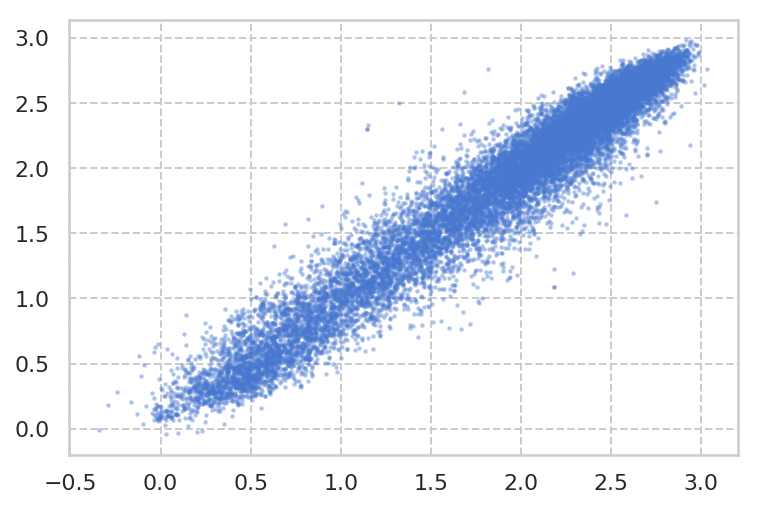

In [40]:
plt.scatter(oof_pred_lgb, oof_pred_xgb, alpha=0.3, s=2)

In [41]:
class DistAdjuster():
    def __init__(self, target):
        dist = Counter(target)
        for k in dist:
            dist[k] /= len(target)

        print("[dist]")
        print(dist)
        self.dist = dist
    
    def adjust(self, pred):
        acum = 0
        self.bound = {}
        for i in range(3):
            acum += self.dist[i]
            self.bound[i] = np.percentile(pred, acum * 100)
        print(self.bound)
        
    def classify(self, x):
        if x <= self.bound[0]:
            return 0
        elif x <= self.bound[1]:
            return 1
        elif x <= self.bound[2]:
            return 2
        else:
            return 3
        
    def fit(self, pred):
        return np.array(list(map(self.classify, pred)))

In [42]:
da = DistAdjuster(y)
p = best_thresh
pred_blending = np.sum([oof_pred_lgb*p, oof_pred_xgb*(1-p)], axis=0)
da.adjust(pred_blending)
pred_blending_mod = da.fit(pred_blending)

[dist]
Counter({3: 0.5, 0: 0.2390616167326173, 1: 0.13629169022046353, 2: 0.12464669304691917})
{0: 1.3256786284518802, 1: 1.819575259064671, 2: 2.0949365172867522}


In [43]:
score = cohen_kappa_score(pred_blending_mod, y, weights='quadratic')
print(f"seed ave: qwk score = {score}")

seed ave: qwk score = 0.5835782621257799


0    4229
1    2411
2    2205
3    8845
dtype: int64

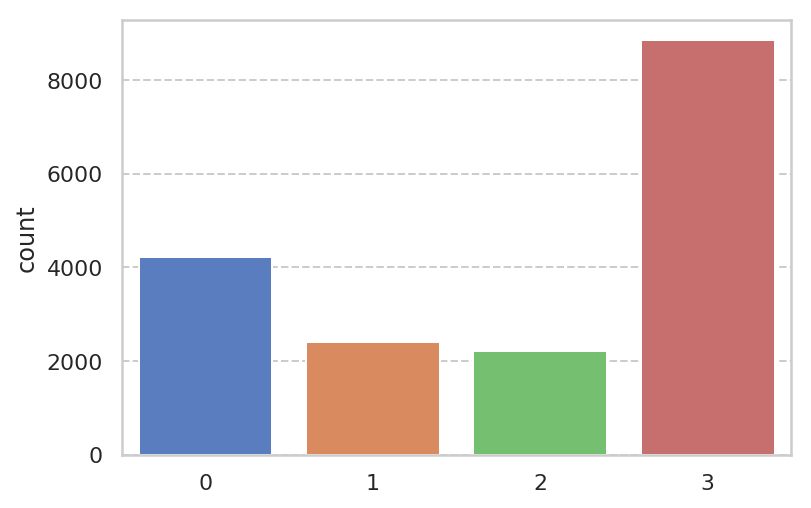

In [44]:
sns.countplot(pred_blending_mod)
pd.Series(pred_blending_mod).value_counts().sort_index()

In [45]:
da = DistAdjuster(y)
p = best_thresh
pred_blending_test = np.sum([y_pred_test_lgb*p, y_pred_test_xgb*(1-p)], axis=0)
da.adjust(pred_blending_test)
pred_blending_test_mod = da.fit(pred_blending_test)

[dist]
Counter({3: 0.5, 0: 0.2390616167326173, 1: 0.13629169022046353, 2: 0.12464669304691917})
{0: 1.4347146594288243, 1: 1.8246272150922724, 2: 2.053461320431547}


0    239
1    136
2    125
3    500
dtype: int64

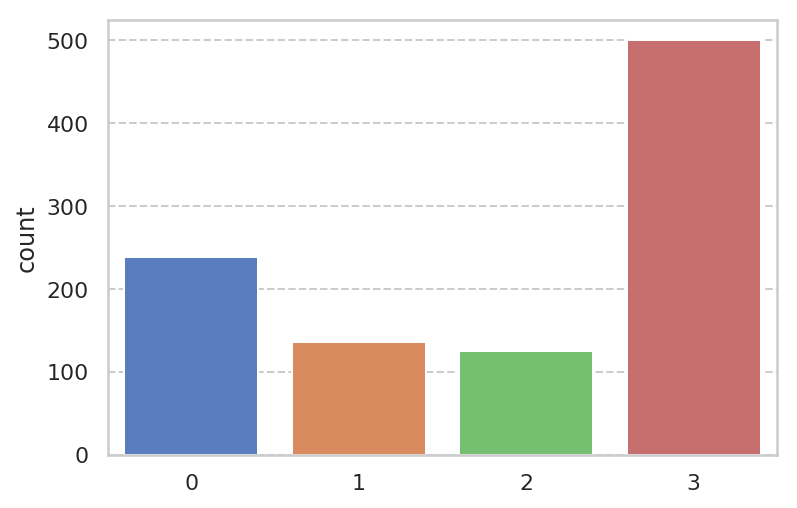

In [46]:
sns.countplot(pred_blending_test_mod)
pd.Series(pred_blending_test_mod).value_counts().sort_index()

In [47]:
submission = pd.read_csv(INPUT_PATH/'sample_submission.csv')
submission['accuracy_group'] = pred_blending_test_mod
submission.to_csv(SUBMIT_PATH/'submission.csv', index=None)
submission.head()


,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,2
